In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from optbinning import BinningProcess

# set col width
pd.set_option('display.max_colwidth', 100)

# set plot style
plt.style.use('seaborn-whitegrid')

# set palette
sns.set_palette('Set1')

(CVXPY) Dec 13 04:18:25 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 13 04:18:25 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_78061/4023470249.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
def create_features(df):
    new_features = {
        # % LOADING OF CREDIT LIMIT PER CUSTOMER
        'PERCENTAGE_LOADING_OF_CREDIT_LIMIT': df['AMT_BALANCE'] / df['AMT_CREDIT_LIMIT_ACTUAL'],
        # RATE OF PAYBACK OF LOANS
        'RATE_OF_PAYBACK': df['AMT_PAYMENT_CURRENT'] / df['AMT_INST_MIN_REGULARITY'],
        # DAY PAST DUE FLAG
        'DPD_FLAG': df['SK_DPD'] > 0,
        # % of MINIMUM PAYMENTS MISSED
        'PERCENTAGE_OF_MINIMUM_PAYMENTS_MISSED': df['AMT_PAYMENT_CURRENT'] / df['AMT_INST_MIN_REGULARITY'],
        #  RATIO OF CASH VS CARD SWIPES
        # 'RATIO_OF_CASH_VS_CARD_SWIPES': df['CNT_DRAWINGS_ATM_CURRENT'] / df['CNT_DRAWINGS_CURRENT'],
        # Minimum Payments Only
        'MINIMUM_PAYMENTS_ONLY': df['AMT_PAYMENT_CURRENT'] == df['AMT_INST_MIN_REGULARITY'],
        # Utilization Rate
        'UTILIZATION_RATE': df['AMT_BALANCE'] / df['AMT_CREDIT_LIMIT_ACTUAL'],
        # Increasing Debt Load
        'INCREASING_DEBT_LOAD': df['AMT_BALANCE'] > df['AMT_BALANCE'].shift(1),
        # Changes in Spending Patterns
        'CHANGES_IN_SPENDING_PATTERNS': df['AMT_DRAWINGS_CURRENT'] > df['AMT_DRAWINGS_CURRENT'].shift(1),
        # Overlimit Flag
        'OVERLIMIT_FLAG': df['AMT_BALANCE'] > df['AMT_CREDIT_LIMIT_ACTUAL'],
        # Rapid Account Turnover
        'RAPID_ACCOUNT_TURNOVER': df['CNT_DRAWINGS_CURRENT'] > df['CNT_DRAWINGS_CURRENT'].shift(1),
    }
    
    df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    return df

In [3]:
df = pd.read_csv('../raw-data/dseb63_credit_card_balance.csv')
df_copy = df.copy()
df.head()

SK_ID_PREV  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
0     2582071              -1    63975.555                    45000   
1     2582071             -82    16809.210                    67500   
2     2582071             -84    27577.890                    67500   
3     2582071              -7    65159.235                    45000   
4     2582071             -59    70475.850                    67500   

   AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                    2250.0                2250.0                         0.0   
1                       0.0                   0.0                         0.0   
2                       0.0                   0.0                         0.0   
3                       0.0                   0.0                         0.0   
4                   24750.0               24750.0                         0.0   

   AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
0                       0.0                   2250.0               2250.0   
1                       0.0                   3375.0               9000.0   
2                       0.0                   3375.0               4500.0   
3                       0.0                   2250.0               2250.0   
4                       0.0                   3375.0               4500.0   

   ...  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
0  ...             64875.555                       1.0                     1   
1  ...             16809.210                       0.0                     0   
2  ...             27577.890                       0.0                     0   
3  ...             65609.235                       0.0                     0   
4  ...             70475.850                       4.0                     4   

   CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       0.0   

   CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  \
0                       69.0                Active       0           0   
1                       18.0                Active       0           0   
2                       16.0                Active       0           0   
3                       63.0                Active       0           0   
4                       41.0                Active       0           0   

  SK_ID_CURR  
0      87788  
1      87788  
2      87788  
3      87788  
4      87788  

[5 rows x 23 columns]

In [4]:
target = pd.read_csv('../processed-data/target.csv')
target.head()

SK_ID_CURR  TARGET
0           0       0
1           1       1
2           2       0
3           3       0
4           4       0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227965 entries, 0 to 3227964
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   MONTHS_BALANCE              int64  
 2   AMT_BALANCE                 float64
 3   AMT_CREDIT_LIMIT_ACTUAL     int64  
 4   AMT_DRAWINGS_ATM_CURRENT    float64
 5   AMT_DRAWINGS_CURRENT        float64
 6   AMT_DRAWINGS_OTHER_CURRENT  float64
 7   AMT_DRAWINGS_POS_CURRENT    float64
 8   AMT_INST_MIN_REGULARITY     float64
 9   AMT_PAYMENT_CURRENT         float64
 10  AMT_PAYMENT_TOTAL_CURRENT   float64
 11  AMT_RECEIVABLE_PRINCIPAL    float64
 12  AMT_RECIVABLE               float64
 13  AMT_TOTAL_RECEIVABLE        float64
 14  CNT_DRAWINGS_ATM_CURRENT    float64
 15  CNT_DRAWINGS_CURRENT        int64  
 16  CNT_DRAWINGS_OTHER_CURRENT  float64
 17  CNT_DRAWINGS_POS_CURRENT    float64
 18  CNT_INSTALMENT_MATURE_CUM   float64
 19  NAME_CONTRACT_STATUS 

In [6]:
df = create_features(df)
df

SK_ID_PREV  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
0           2582071              -1    63975.555                    45000   
1           2582071             -82    16809.210                    67500   
2           2582071             -84    27577.890                    67500   
3           2582071              -7    65159.235                    45000   
4           2582071             -59    70475.850                    67500   
...             ...             ...          ...                      ...   
3227960     1551072              -1        0.000                   202500   
3227961     2339982              -1        0.000                    45000   
3227962     2720102              -1        0.000                   225000   
3227963     1897864              -2        0.000                   270000   
3227964     2481982              -1        0.000                   270000   

         AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                          2250.0                2250.0   
1                             0.0                   0.0   
2                             0.0                   0.0   
3                             0.0                   0.0   
4                         24750.0               24750.0   
...                           ...                   ...   
3227960                       NaN                   0.0   
3227961                       0.0                   0.0   
3227962                       NaN                   0.0   
3227963                       NaN                   0.0   
3227964                       NaN                   0.0   

         AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                               0.0                       0.0   
1                               0.0                       0.0   
2                               0.0                       0.0   
3                               0.0                       0.0   
4                               0.0                       0.0   
...                             ...                       ...   
3227960                         NaN                       NaN   
3227961                         0.0                       0.0   
3227962                         NaN                       NaN   
3227963                         NaN                       NaN   
3227964                         NaN                       NaN   

         AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  ...  \
0                         2250.0               2250.0  ...   
1                         3375.0               9000.0  ...   
2                         3375.0               4500.0  ...   
3                         2250.0               2250.0  ...   
4                         3375.0               4500.0  ...   
...                          ...                  ...  ...   
3227960                      0.0                  NaN  ...   
3227961                      0.0                  NaN  ...   
3227962                      0.0                  NaN  ...   
3227963                      0.0                  NaN  ...   
3227964                      0.0                  NaN  ...   

         PERCENTAGE_LOADING_OF_CREDIT_LIMIT  RATE_OF_PAYBACK  DPD_FLAG  \
0                                  1.421679         1.000000     False   
1                                  0.249025         2.666667     False   
2                                  0.408561         1.333333     False   
3                                  1.447983         1.000000     False   
4                                  1.044087         1.333333     False   
...                                     ...              ...       ...   
3227960                            0.000000              NaN     False   
3227961                            0.000000              NaN     False   
3227962                            0.000000              NaN     False   
3227963                            0.000000              NaN     False   
3227964                            

# EDA

In [7]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
# remove sk_id_prev, sk_id_curr
num_cols.remove('SK_ID_PREV')
num_cols.remove('SK_ID_CURR')

cat_cols = df.select_dtypes(include='object').columns.tolist()

## Outliers

/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


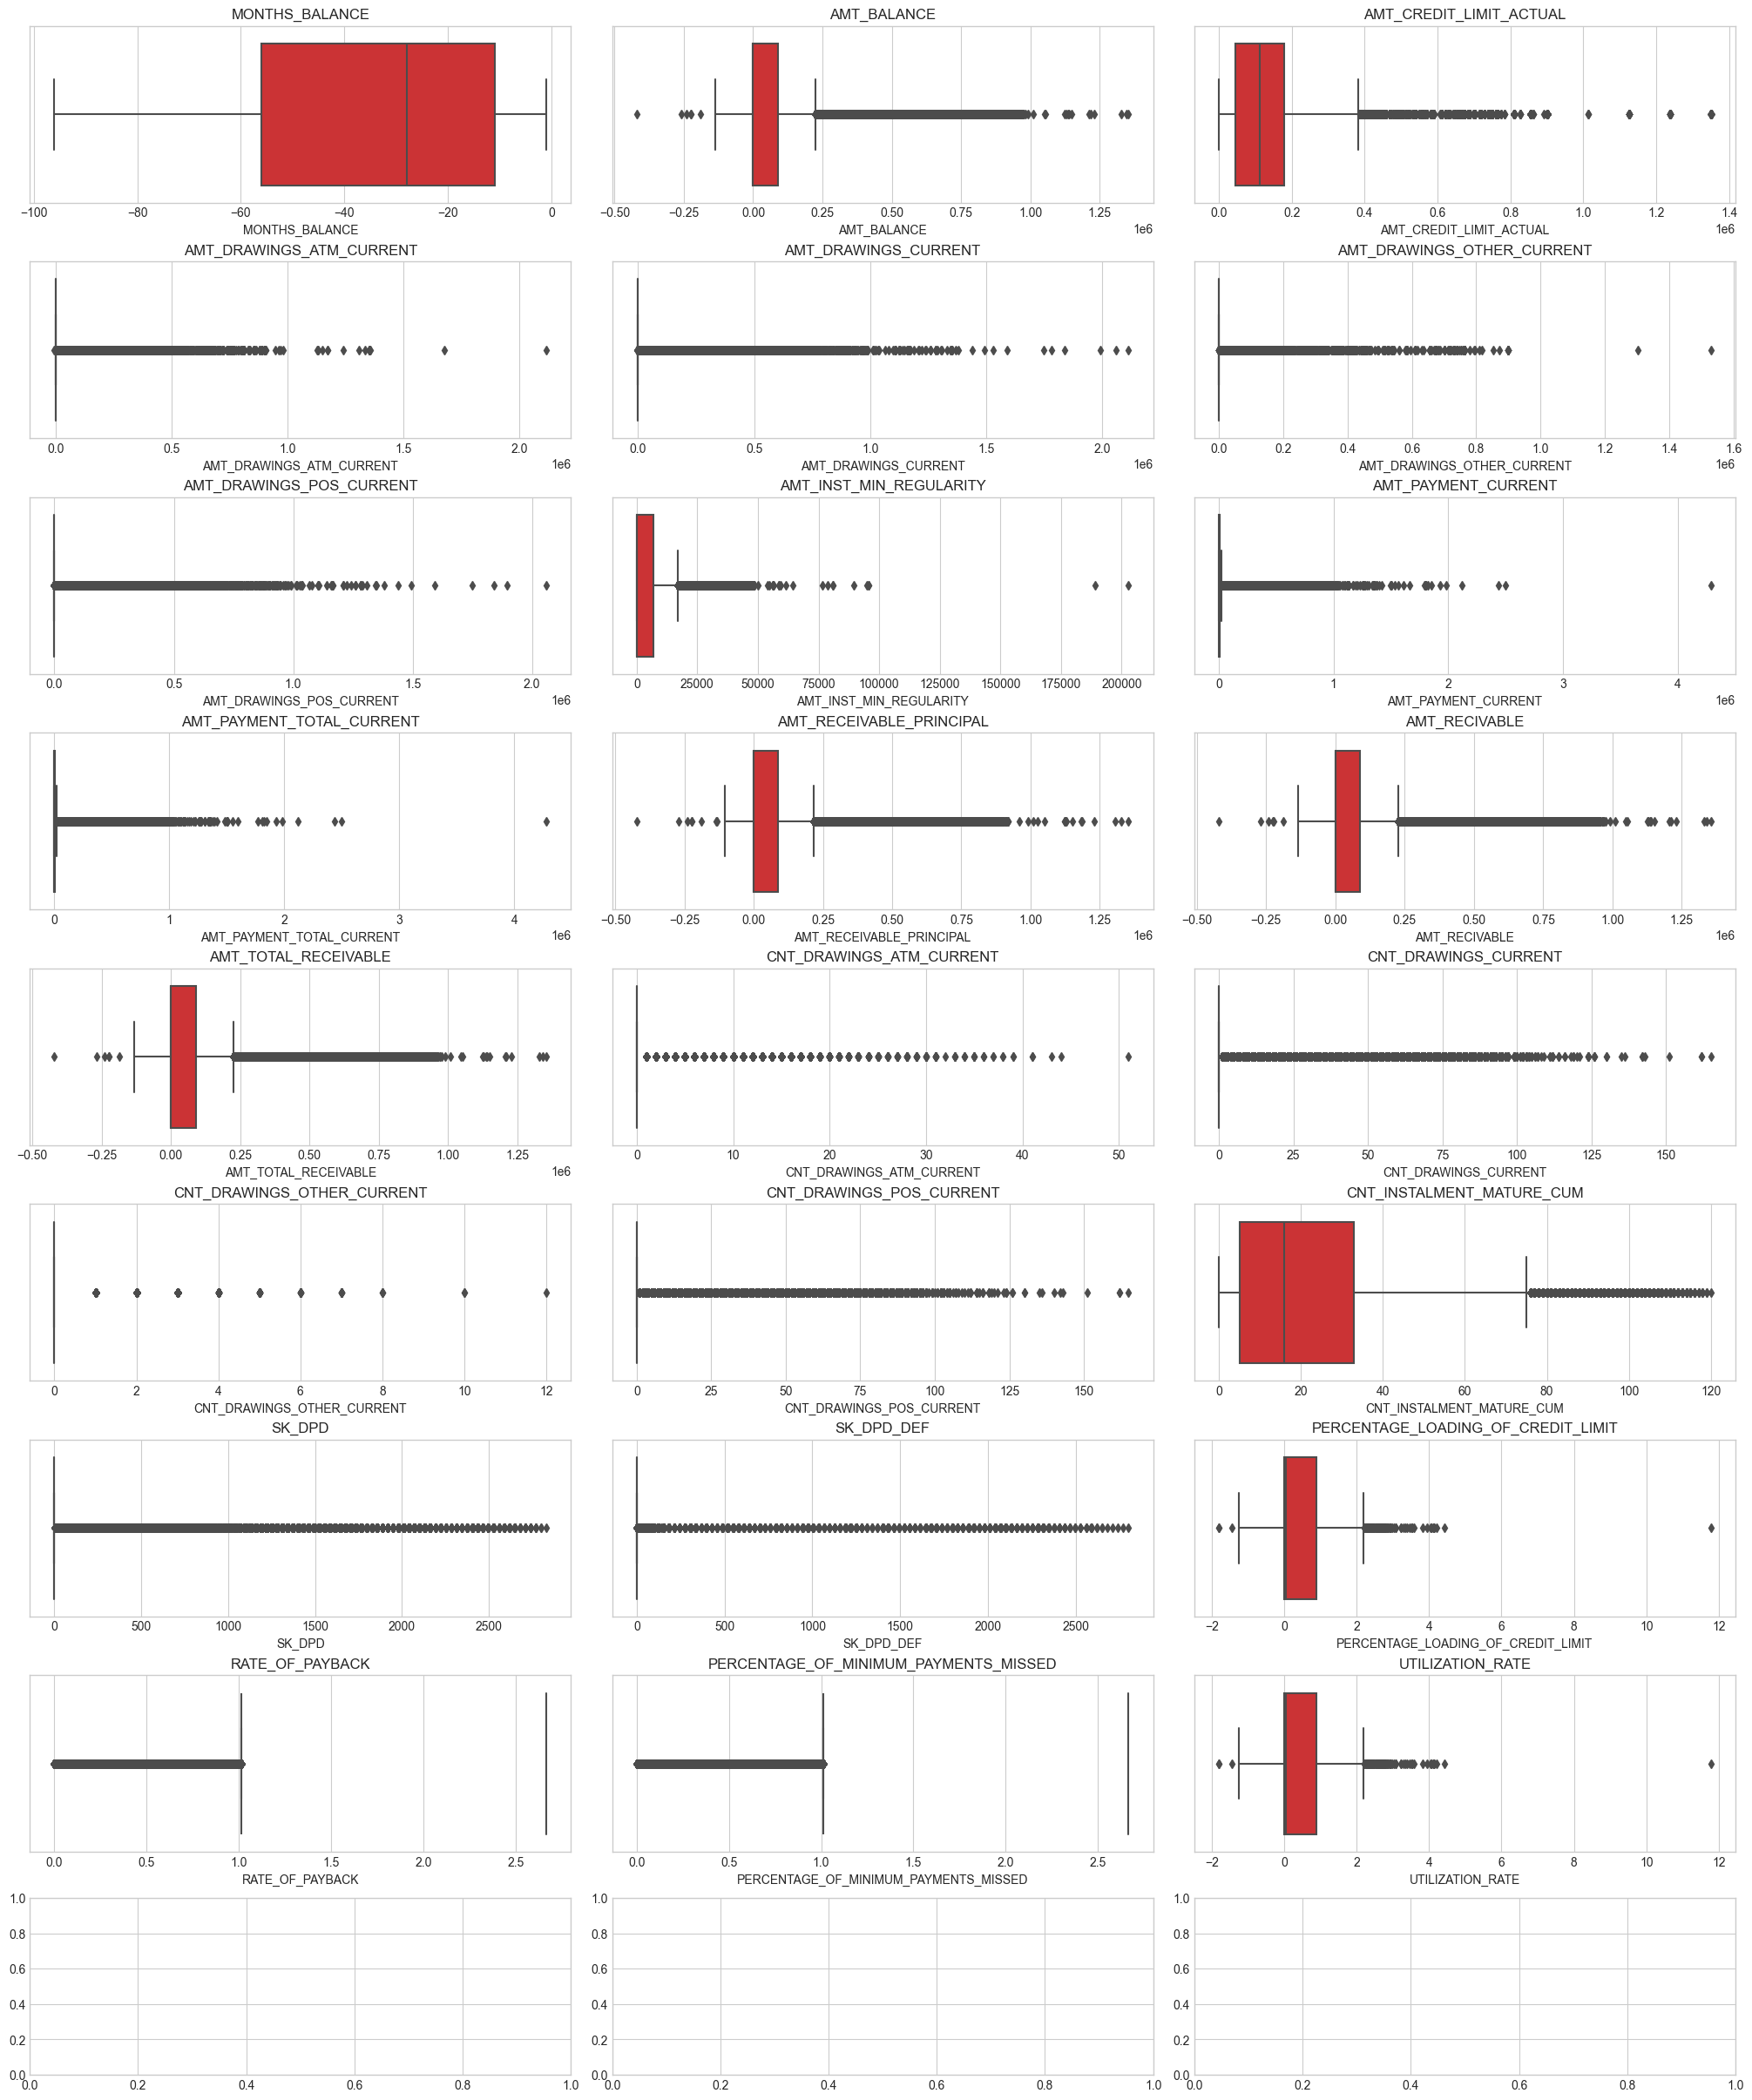

In [8]:
# Boxplot of numerical columns
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(column)

plt.show()

/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


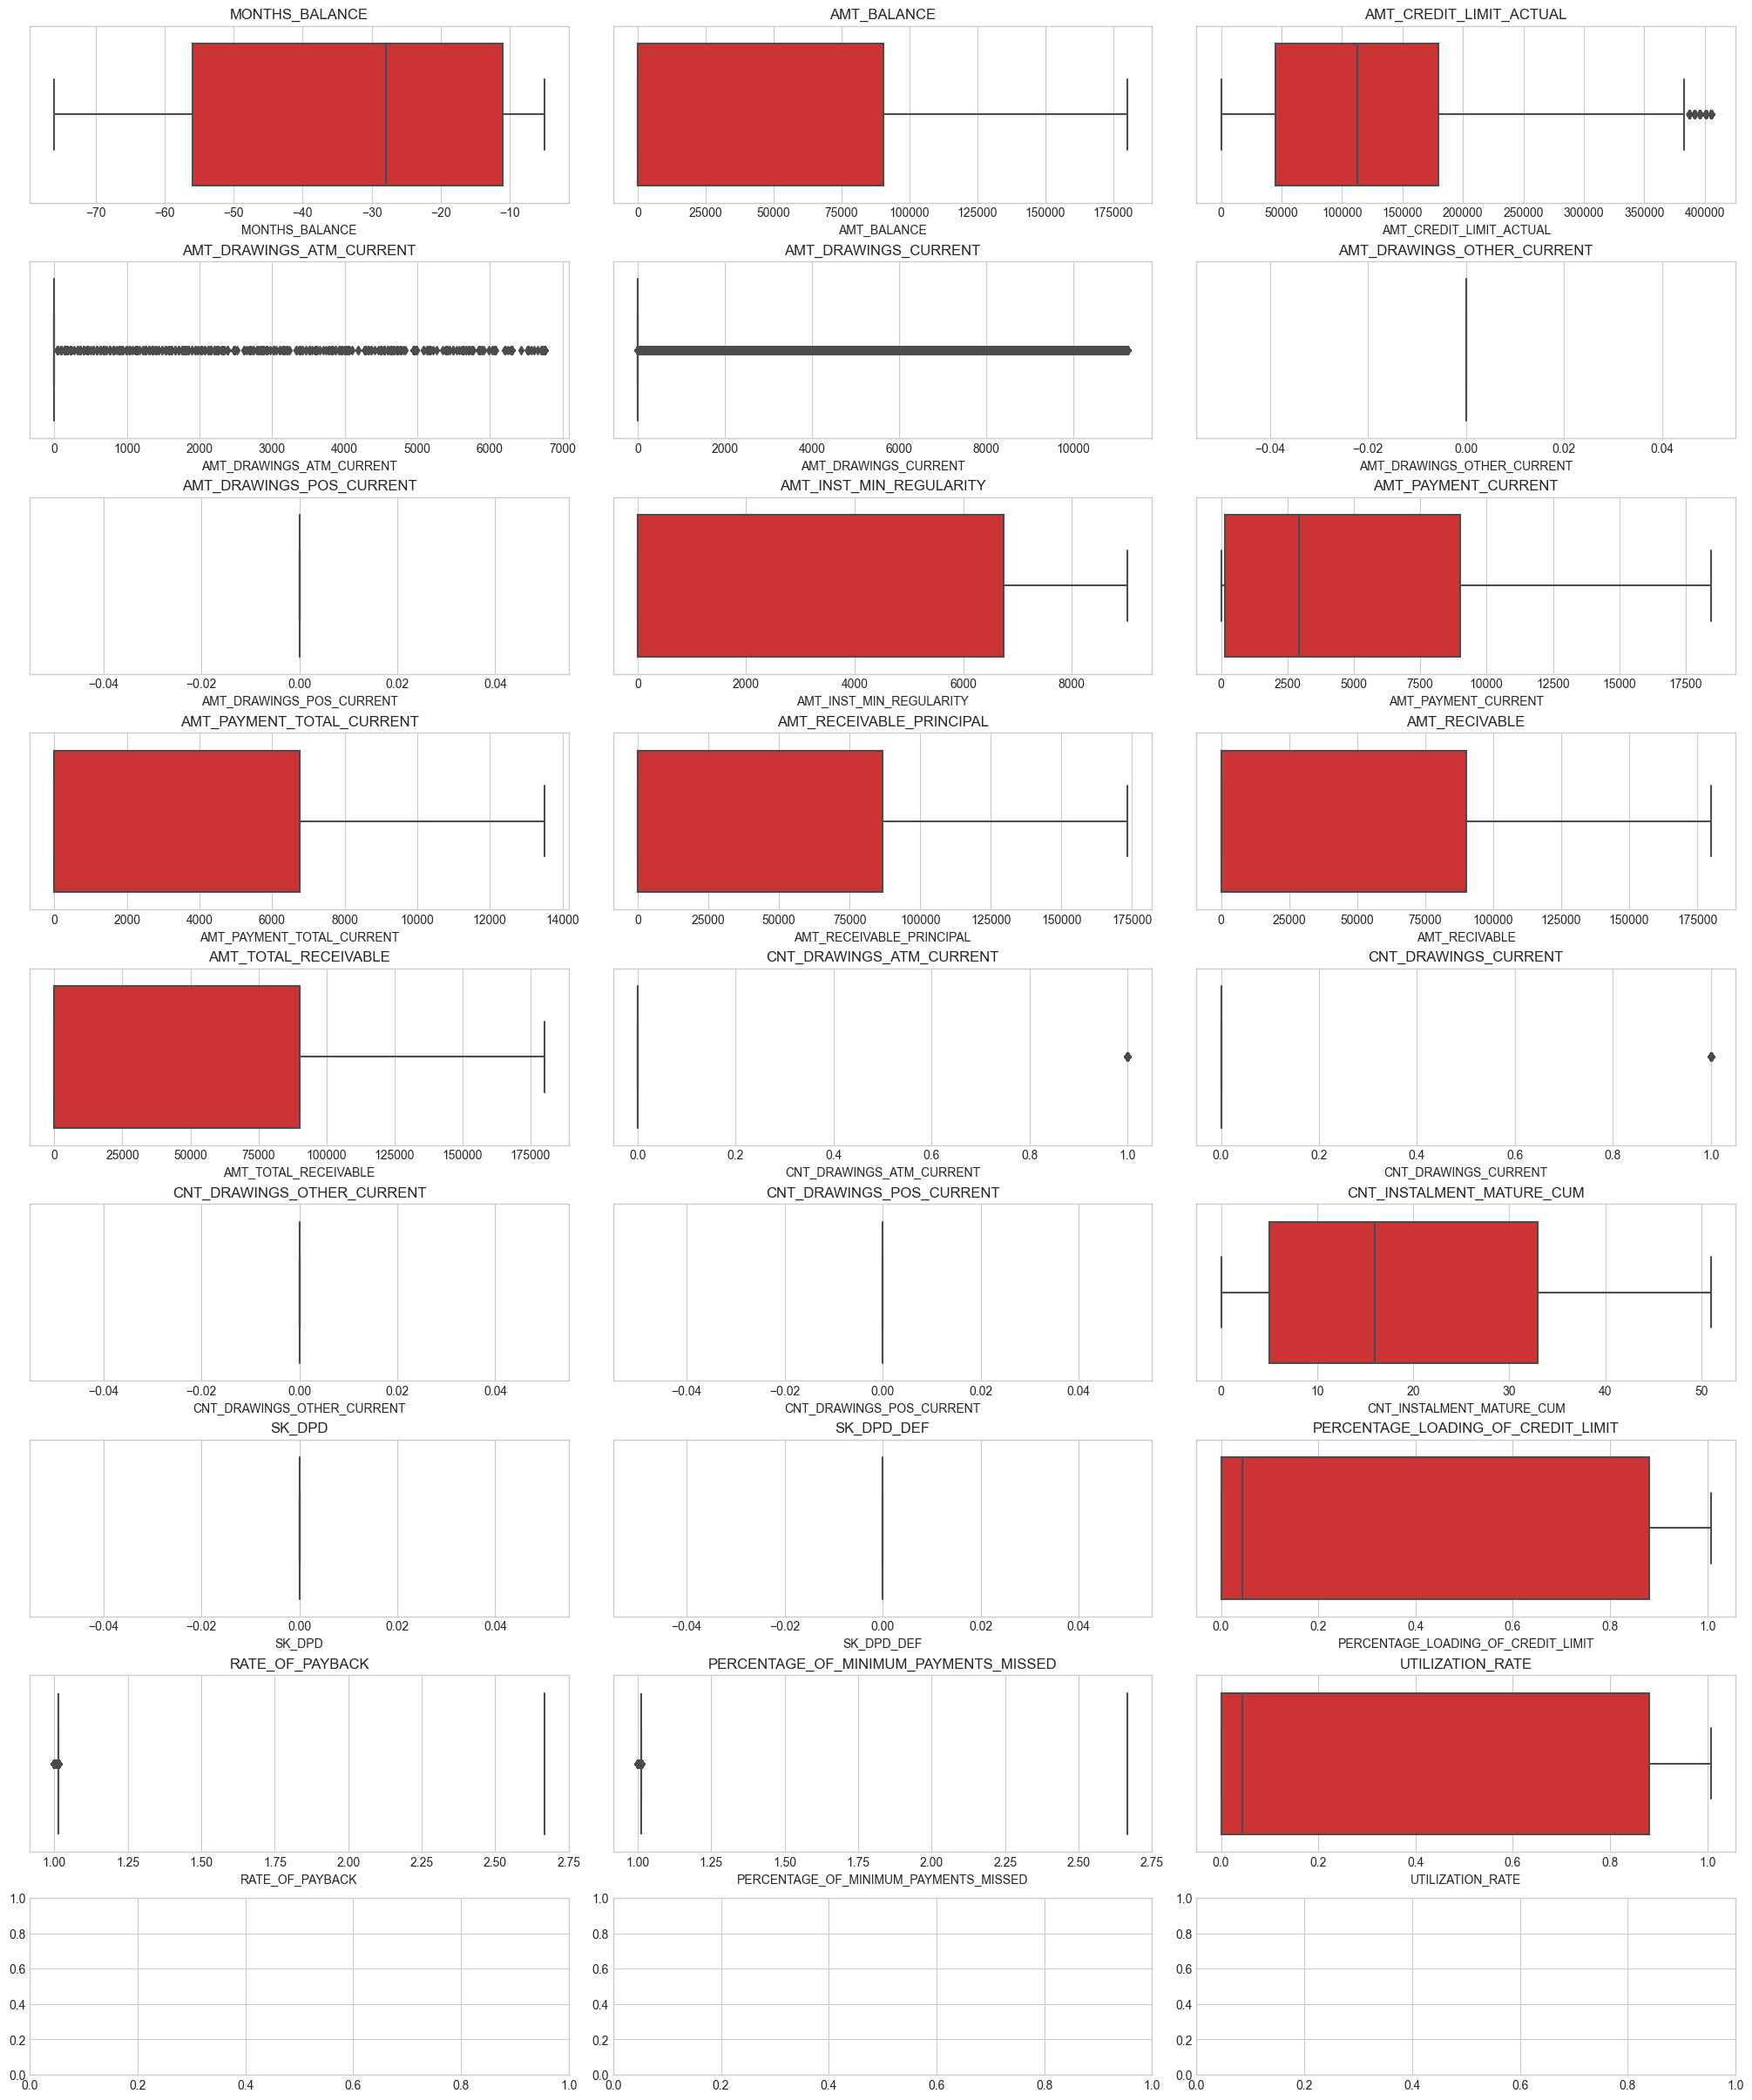

In [9]:
# Clip outliers
for column in num_cols:
    df[column] = df[column].clip(df[column].quantile(0.1), df[column].quantile(0.9))

# Boxplot of numerical columns
ncol, nrow = 3, len(num_cols)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.boxplot(x=df[column], ax=ax)
    ax.set_title(column)

plt.show()

## Descriptive

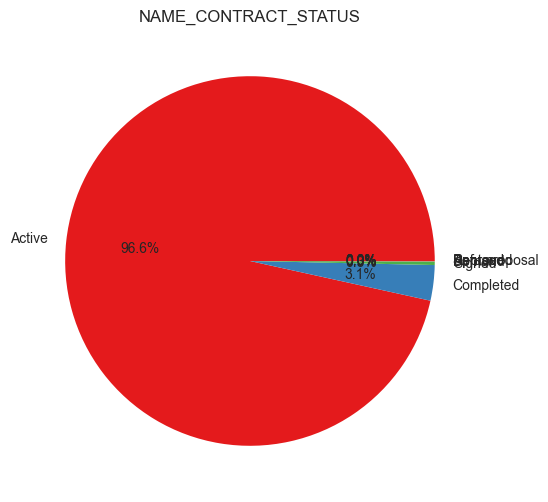

In [10]:
# Pie chart of categorical columns
for col in cat_cols:
    plt.figure(figsize=(6, 6))
    plt.pie(df[col].value_counts(), labels=df[col].value_counts().index.tolist(), autopct='%1.1f%%')
    plt.title(col)
    plt.show()

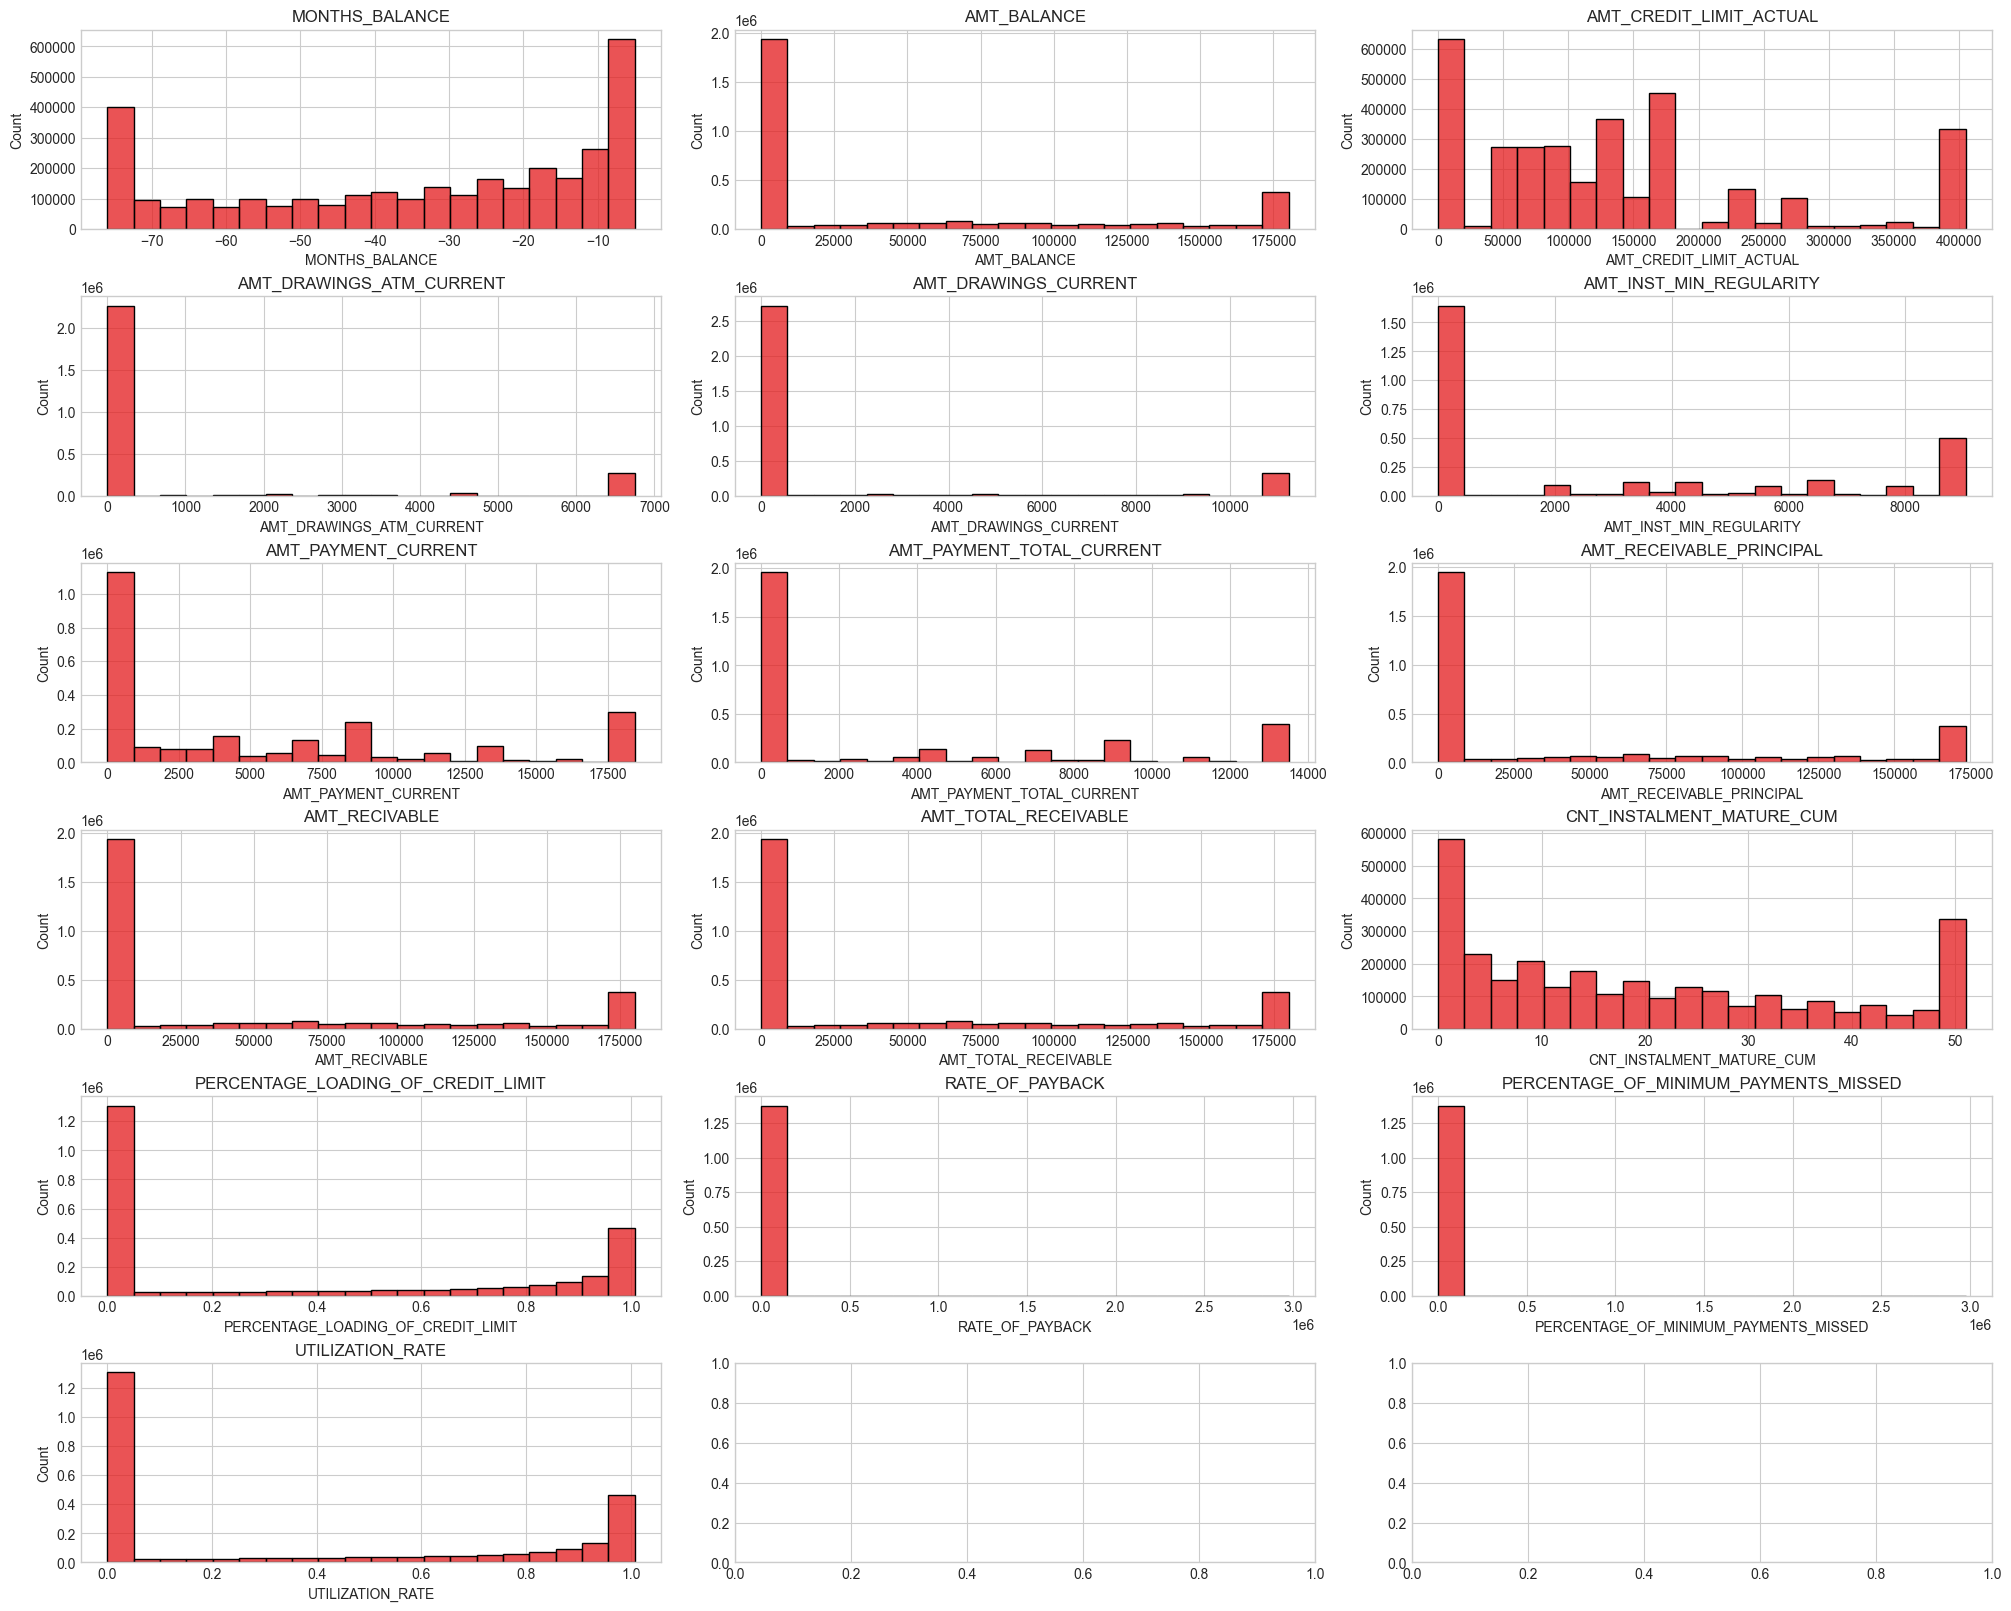

In [11]:
# Plot histogram of numerical columns nunique > 2
cols_to_plot = [col for col in num_cols if df[col].nunique() > 2]
ncol, nrow = 3, len(cols_to_plot)//3 + 1

fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.histplot(x=df[column], ax=ax, bins=20)
    ax.set_title(column)

plt.show()

## Missing Values

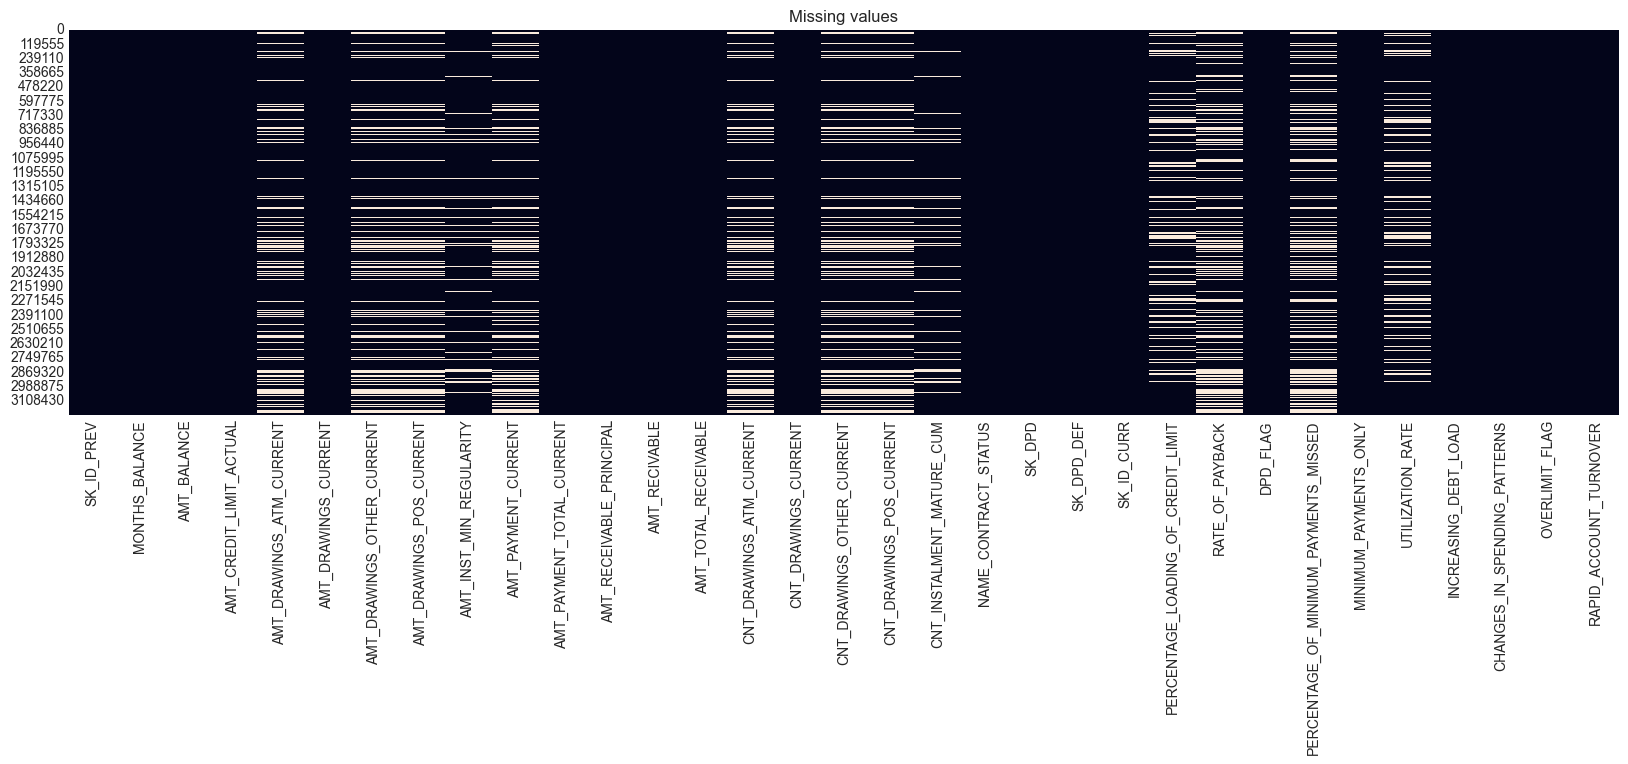

In [12]:
# Heatmap of missing values
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(df.isnull(), ax=ax, cbar=False)
ax.set_title('Missing values')
plt.show()

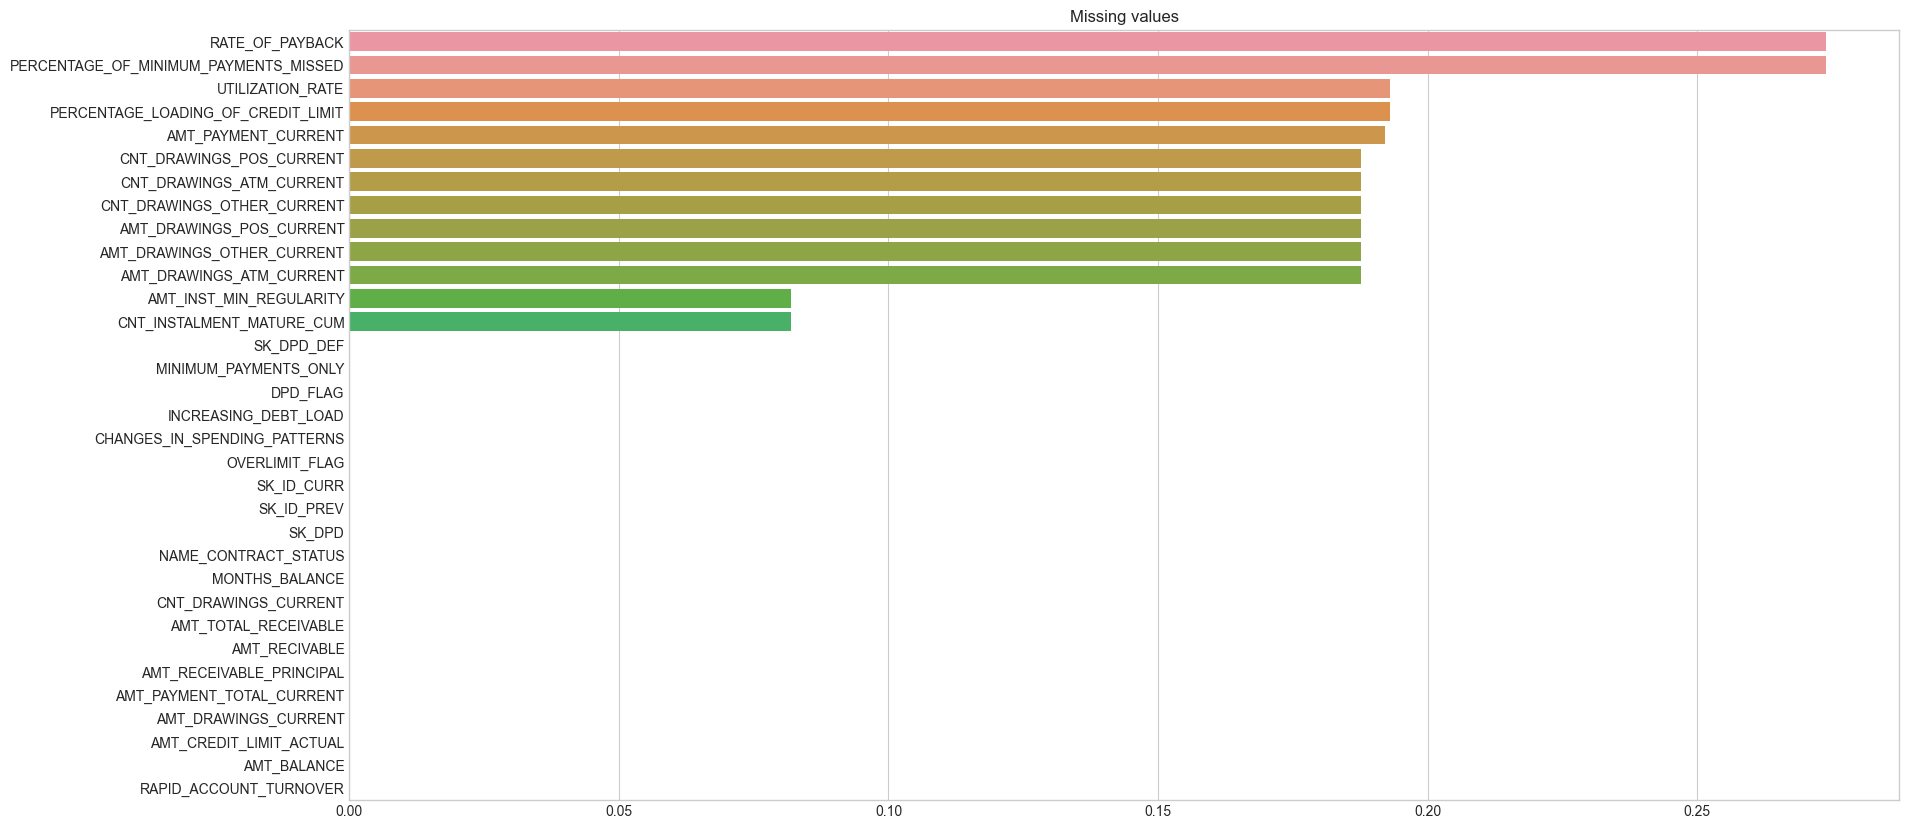

In [13]:
# Horizontal barplot of missing value percentage
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x=df.isnull().mean().sort_values(ascending=False), y=df.isnull().mean().sort_values(ascending=False).index, ax=ax)
ax.set_title('Missing values')
plt.show()

## Correlation

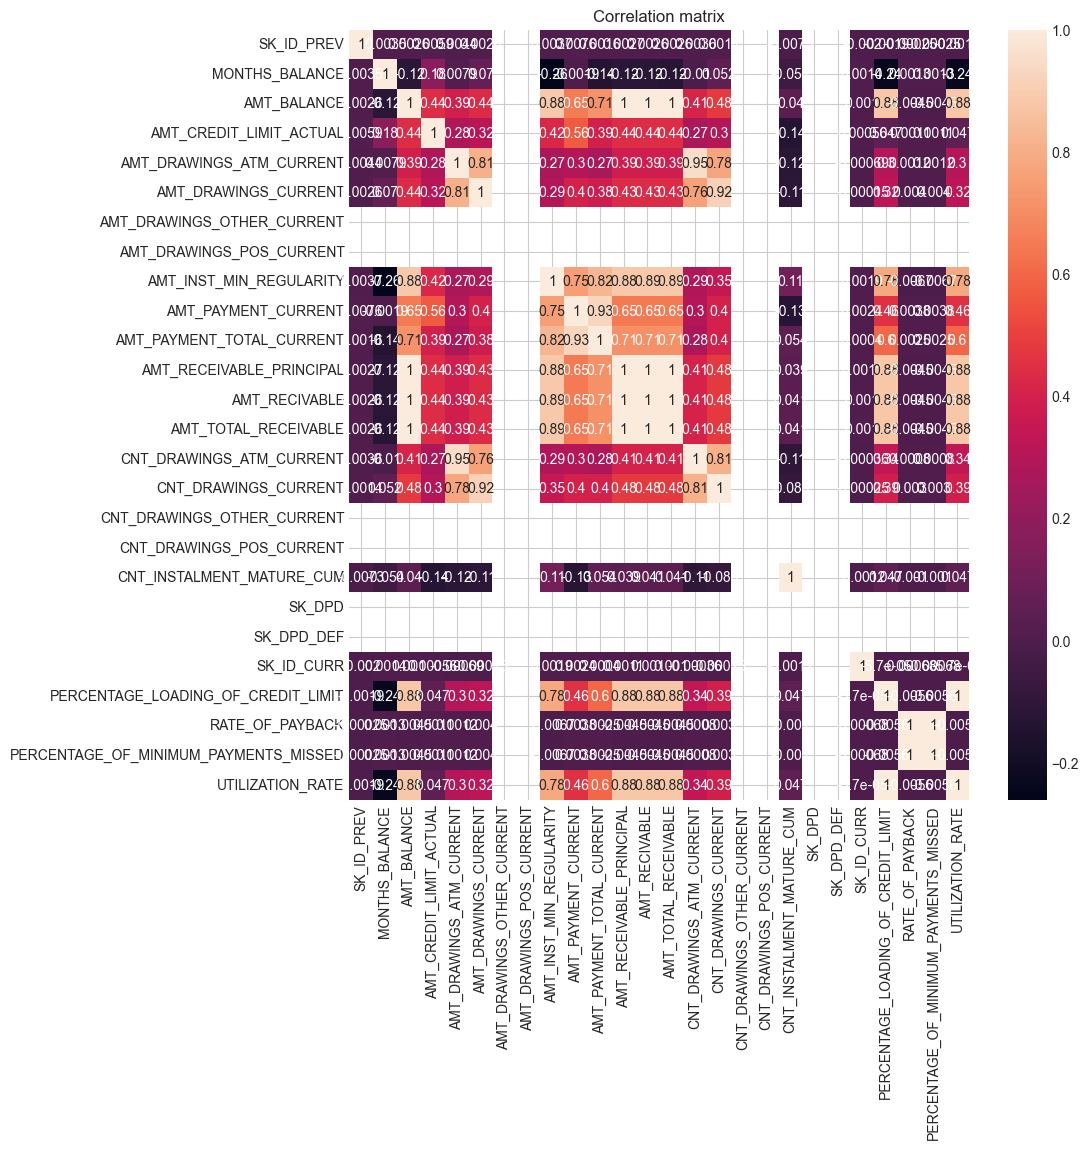

In [ ]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
num_cols = df.select_dtypes(include=np.number).columns.tolist()
sns.heatmap(df[num_cols].corr(), ax=ax,cmap='coolwarm')
ax.set_title('Correlation matrix')
plt.show()

## Merge with TARGET

In [16]:
# Merge with target
df = df.merge(target, on='SK_ID_CURR', how='left')
df.head()

SK_ID_PREV  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
0     2582071              -5    63975.555                    45000   
1     2582071             -76    16809.210                    67500   
2     2582071             -76    27577.890                    67500   
3     2582071              -7    65159.235                    45000   
4     2582071             -59    70475.850                    67500   

   AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                    2250.0                2250.0                         0.0   
1                       0.0                   0.0                         0.0   
2                       0.0                   0.0                         0.0   
3                       0.0                   0.0                         0.0   
4                    6750.0               11250.0                         0.0   

   AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
0                       0.0                   2250.0               2250.0   
1                       0.0                   3375.0               9000.0   
2                       0.0                   3375.0               4500.0   
3                       0.0                   2250.0               2250.0   
4                       0.0                   3375.0               4500.0   

   ...  RATE_OF_PAYBACK  DPD_FLAG  PERCENTAGE_OF_MINIMUM_PAYMENTS_MISSED  \
0  ...         1.000000     False                               1.000000   
1  ...         2.666667     False                               2.666667   
2  ...         1.333333     False                               1.333333   
3  ...         1.000000     False                               1.000000   
4  ...         1.333333     False                               1.333333   

   MINIMUM_PAYMENTS_ONLY  UTILIZATION_RATE  INCREASING_DEBT_LOAD  \
0                   True          1.007531                 False   
1                  False          0.249025                 False   
2                  False          0.408561                  True   
3                   True          1.007531                  True   
4                  False          1.007531                  True   

   CHANGES_IN_SPENDING_PATTERNS  OVERLIMIT_FLAG  RAPID_ACCOUNT_TURNOVER TARGET  
0                         False            True                   False    1.0  
1                         False           False                   False    1.0  
2                         False           False                   False    1.0  
3                         False            True                   False    1.0  
4                          True            True                    True    1.0  

[5 rows x 34 columns]

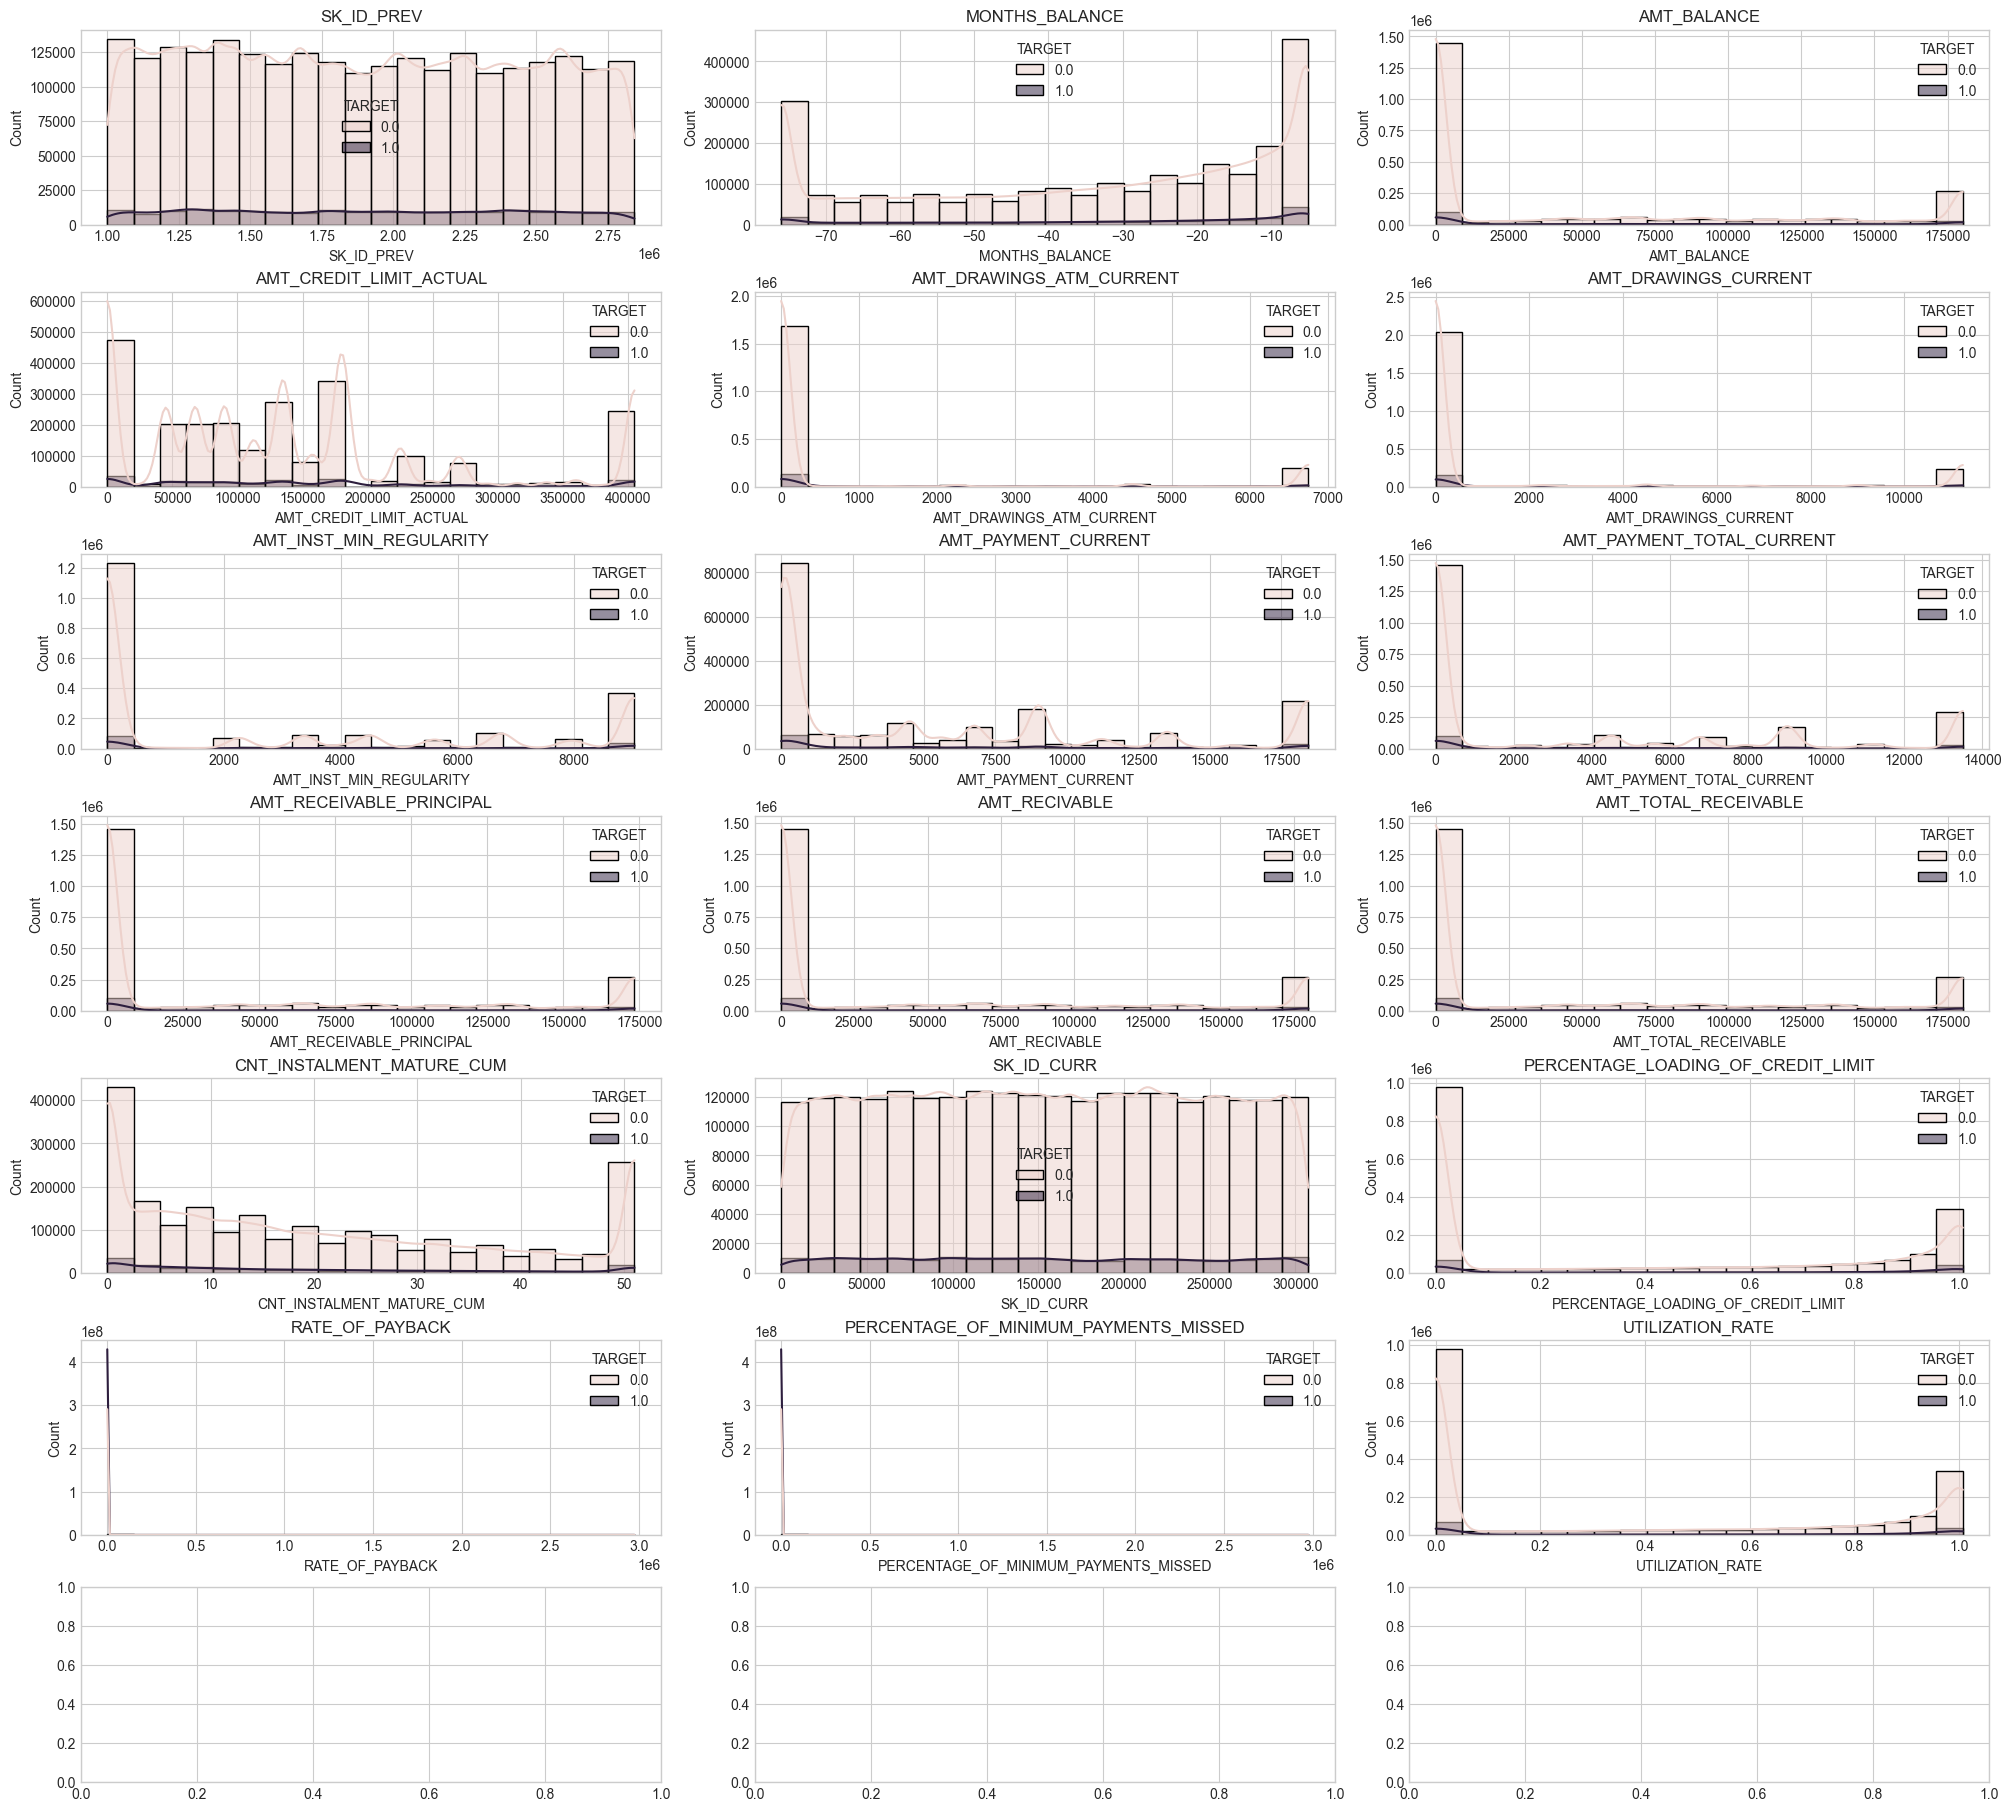

In [17]:
# Plot histogram of numerical columns nunique > 2
cols_to_plot = [col for col in num_cols if df[col].nunique() > 2]
ncol, nrow = 3, len(cols_to_plot)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.histplot(df, x=column, hue='TARGET', ax=ax, bins=20, kde=True)
    ax.set_title(column)

plt.show()

# Group by SK_ID_CURR

In [18]:
df = df_copy.copy()
df.drop(columns=['SK_ID_PREV'], inplace=True)
df = create_features(df)

# Get dummies
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Groupby SK_ID_PREV
grouped = df.groupby('SK_ID_CURR')

## Mean

In [19]:
# Merge with target
df = grouped.mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86905 entries, 0 to 307509
Data columns (total 36 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MONTHS_BALANCE                         86905 non-null  float64
 1   AMT_BALANCE                            86905 non-null  float64
 2   AMT_CREDIT_LIMIT_ACTUAL                86905 non-null  float64
 3   AMT_DRAWINGS_ATM_CURRENT               61140 non-null  float64
 4   AMT_DRAWINGS_CURRENT                   86905 non-null  float64
 5   AMT_DRAWINGS_OTHER_CURRENT             61140 non-null  float64
 6   AMT_DRAWINGS_POS_CURRENT               61140 non-null  float64
 7   AMT_INST_MIN_REGULARITY                86905 non-null  float64
 8   AMT_PAYMENT_CURRENT                    61060 non-null  float64
 9   AMT_PAYMENT_TOTAL_CURRENT              86905 non-null  float64
 10  AMT_RECEIVABLE_PRINCIPAL               86905 non-null  float64
 11  AMT_RE

In [20]:
# Clip outliers
for column in df.columns:
    df[column] = df[column].clip(df[column].quantile(0.1), df[column].quantile(0.9))

# Merge with target
df = df.merge(target, on='SK_ID_CURR', how='left')
df.head()

/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/ngvngoc/Documents/data-preparation-final-project/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


SK_ID_CURR  MONTHS_BALANCE    AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
0           0            -4.5    6735.504375            180000.000000   
1           1            -5.0  147180.880000            225000.000000   
2           3            -6.0  124425.875455            135000.000000   
3           7            -9.5       0.000000             62500.000000   
4           9            -6.0     428.318182            163636.363636   

   AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                  0.000000          14053.455000                         0.0   
1              26000.000000          26000.000000                         0.0   
2                  0.000000          17483.854091                         0.0   
3                       NaN              0.000000                         NaN   
4               6218.181818           6218.181818                         0.0   

   AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
0                14053.4550               281.250000         14310.649286   
1                    0.0000              6675.515000          7678.125000   
2                19232.2395              5517.695455         10061.014500   
3                       NaN                 0.000000                  NaN   
4                    0.0000               204.545455          7131.285000   

   ...  CHANGES_IN_SPENDING_PATTERNS  OVERLIMIT_FLAG  RAPID_ACCOUNT_TURNOVER  \
0  ...                      0.476190        0.000000                0.444444   
1  ...                      0.333333        0.111111                0.222222   
2  ...                      0.272727        0.333333                0.444444   
3  ...                      0.000000        0.000000                0.000000   
4  ...                      0.090909        0.000000                0.090909   

   NAME_CONTRACT_STATUS_Approved  NAME_CONTRACT_STATUS_Completed  \
0                            0.0                        0.000000   
1                            0.0                        0.000000   
2                            0.0                        0.000000   
3                            0.0                        0.066667   
4                            0.0                        0.066667   

   NAME_CONTRACT_STATUS_Demand  NAME_CONTRACT_STATUS_Refused  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   NAME_CONTRACT_STATUS_Sent proposal  NAME_CONTRACT_STATUS_Signed  TARGET  
0                                 0.0                          0.0     0.0  
1                                 0.0                          0.0     1.0  
2                                 0.0                          0.0     0.0  
3                                 0.0                          0.0     0.0  
4                                 0.0                          0.0     0.0  

[5 rows x 38 columns]

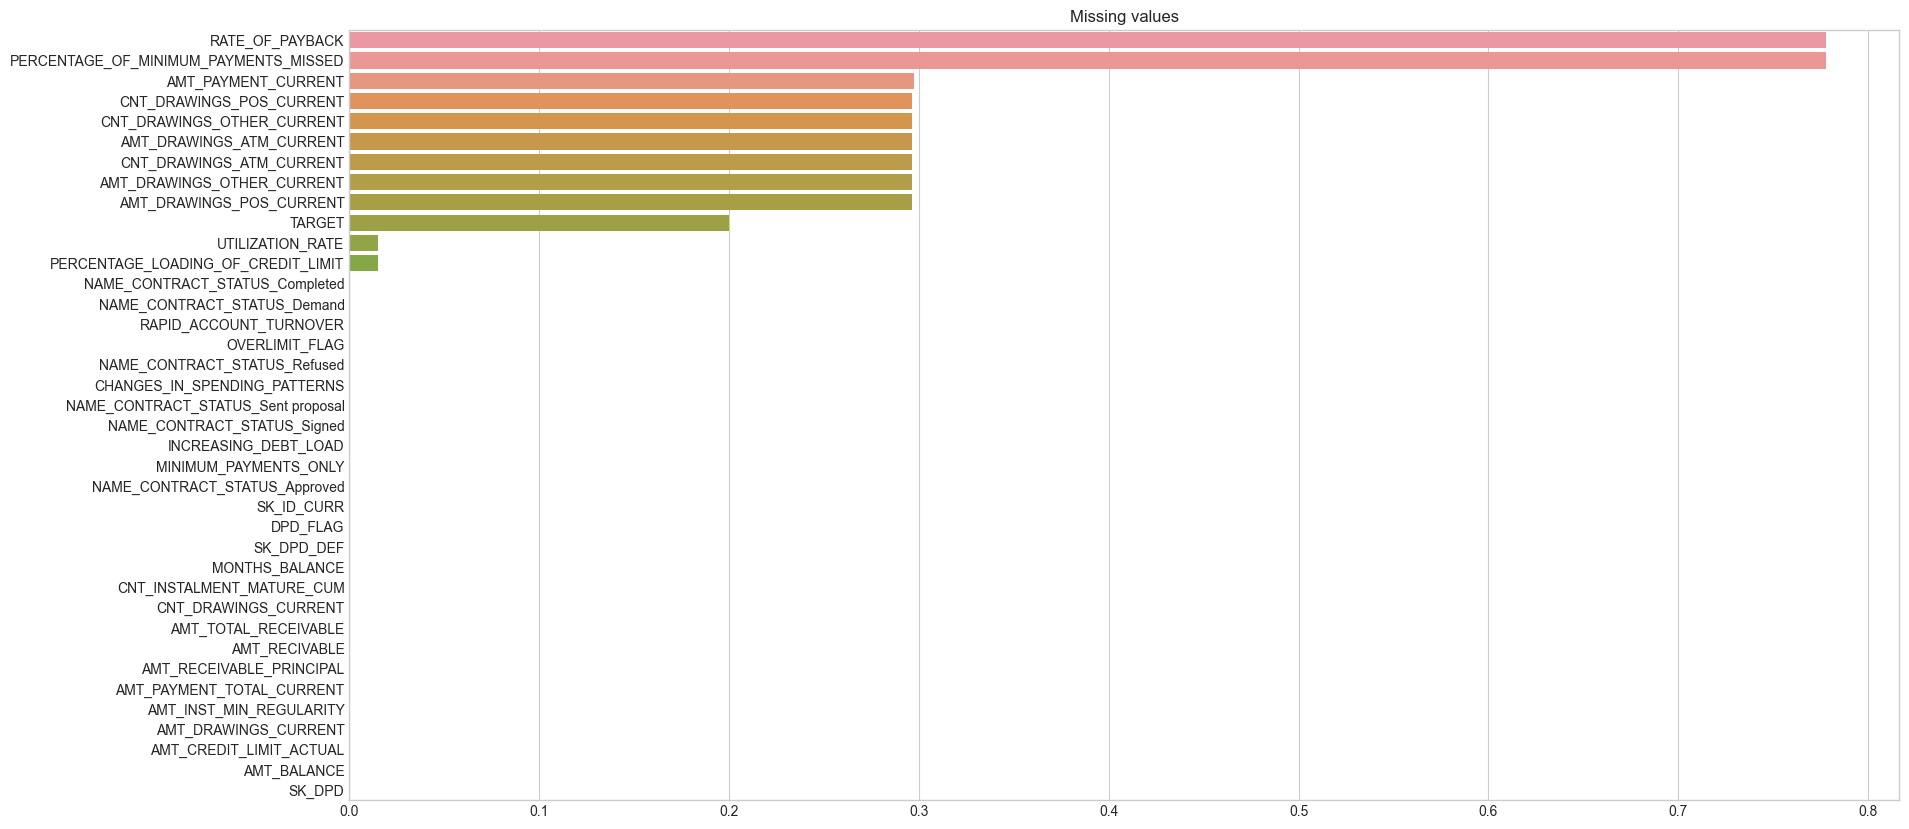

In [21]:
# Plot missing percentage
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x=df.isnull().mean().sort_values(ascending=False), y=df.isnull().mean().sort_values(ascending=False).index, ax=ax)
ax.set_title('Missing values')
plt.show()

/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_78061/672446259.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['TARGET'] == 0, column], ax=ax, label='target = 0')
/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_78061/672446259.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df.loc[df['TARGET'] == 1, column], ax=ax, label='target = 1')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


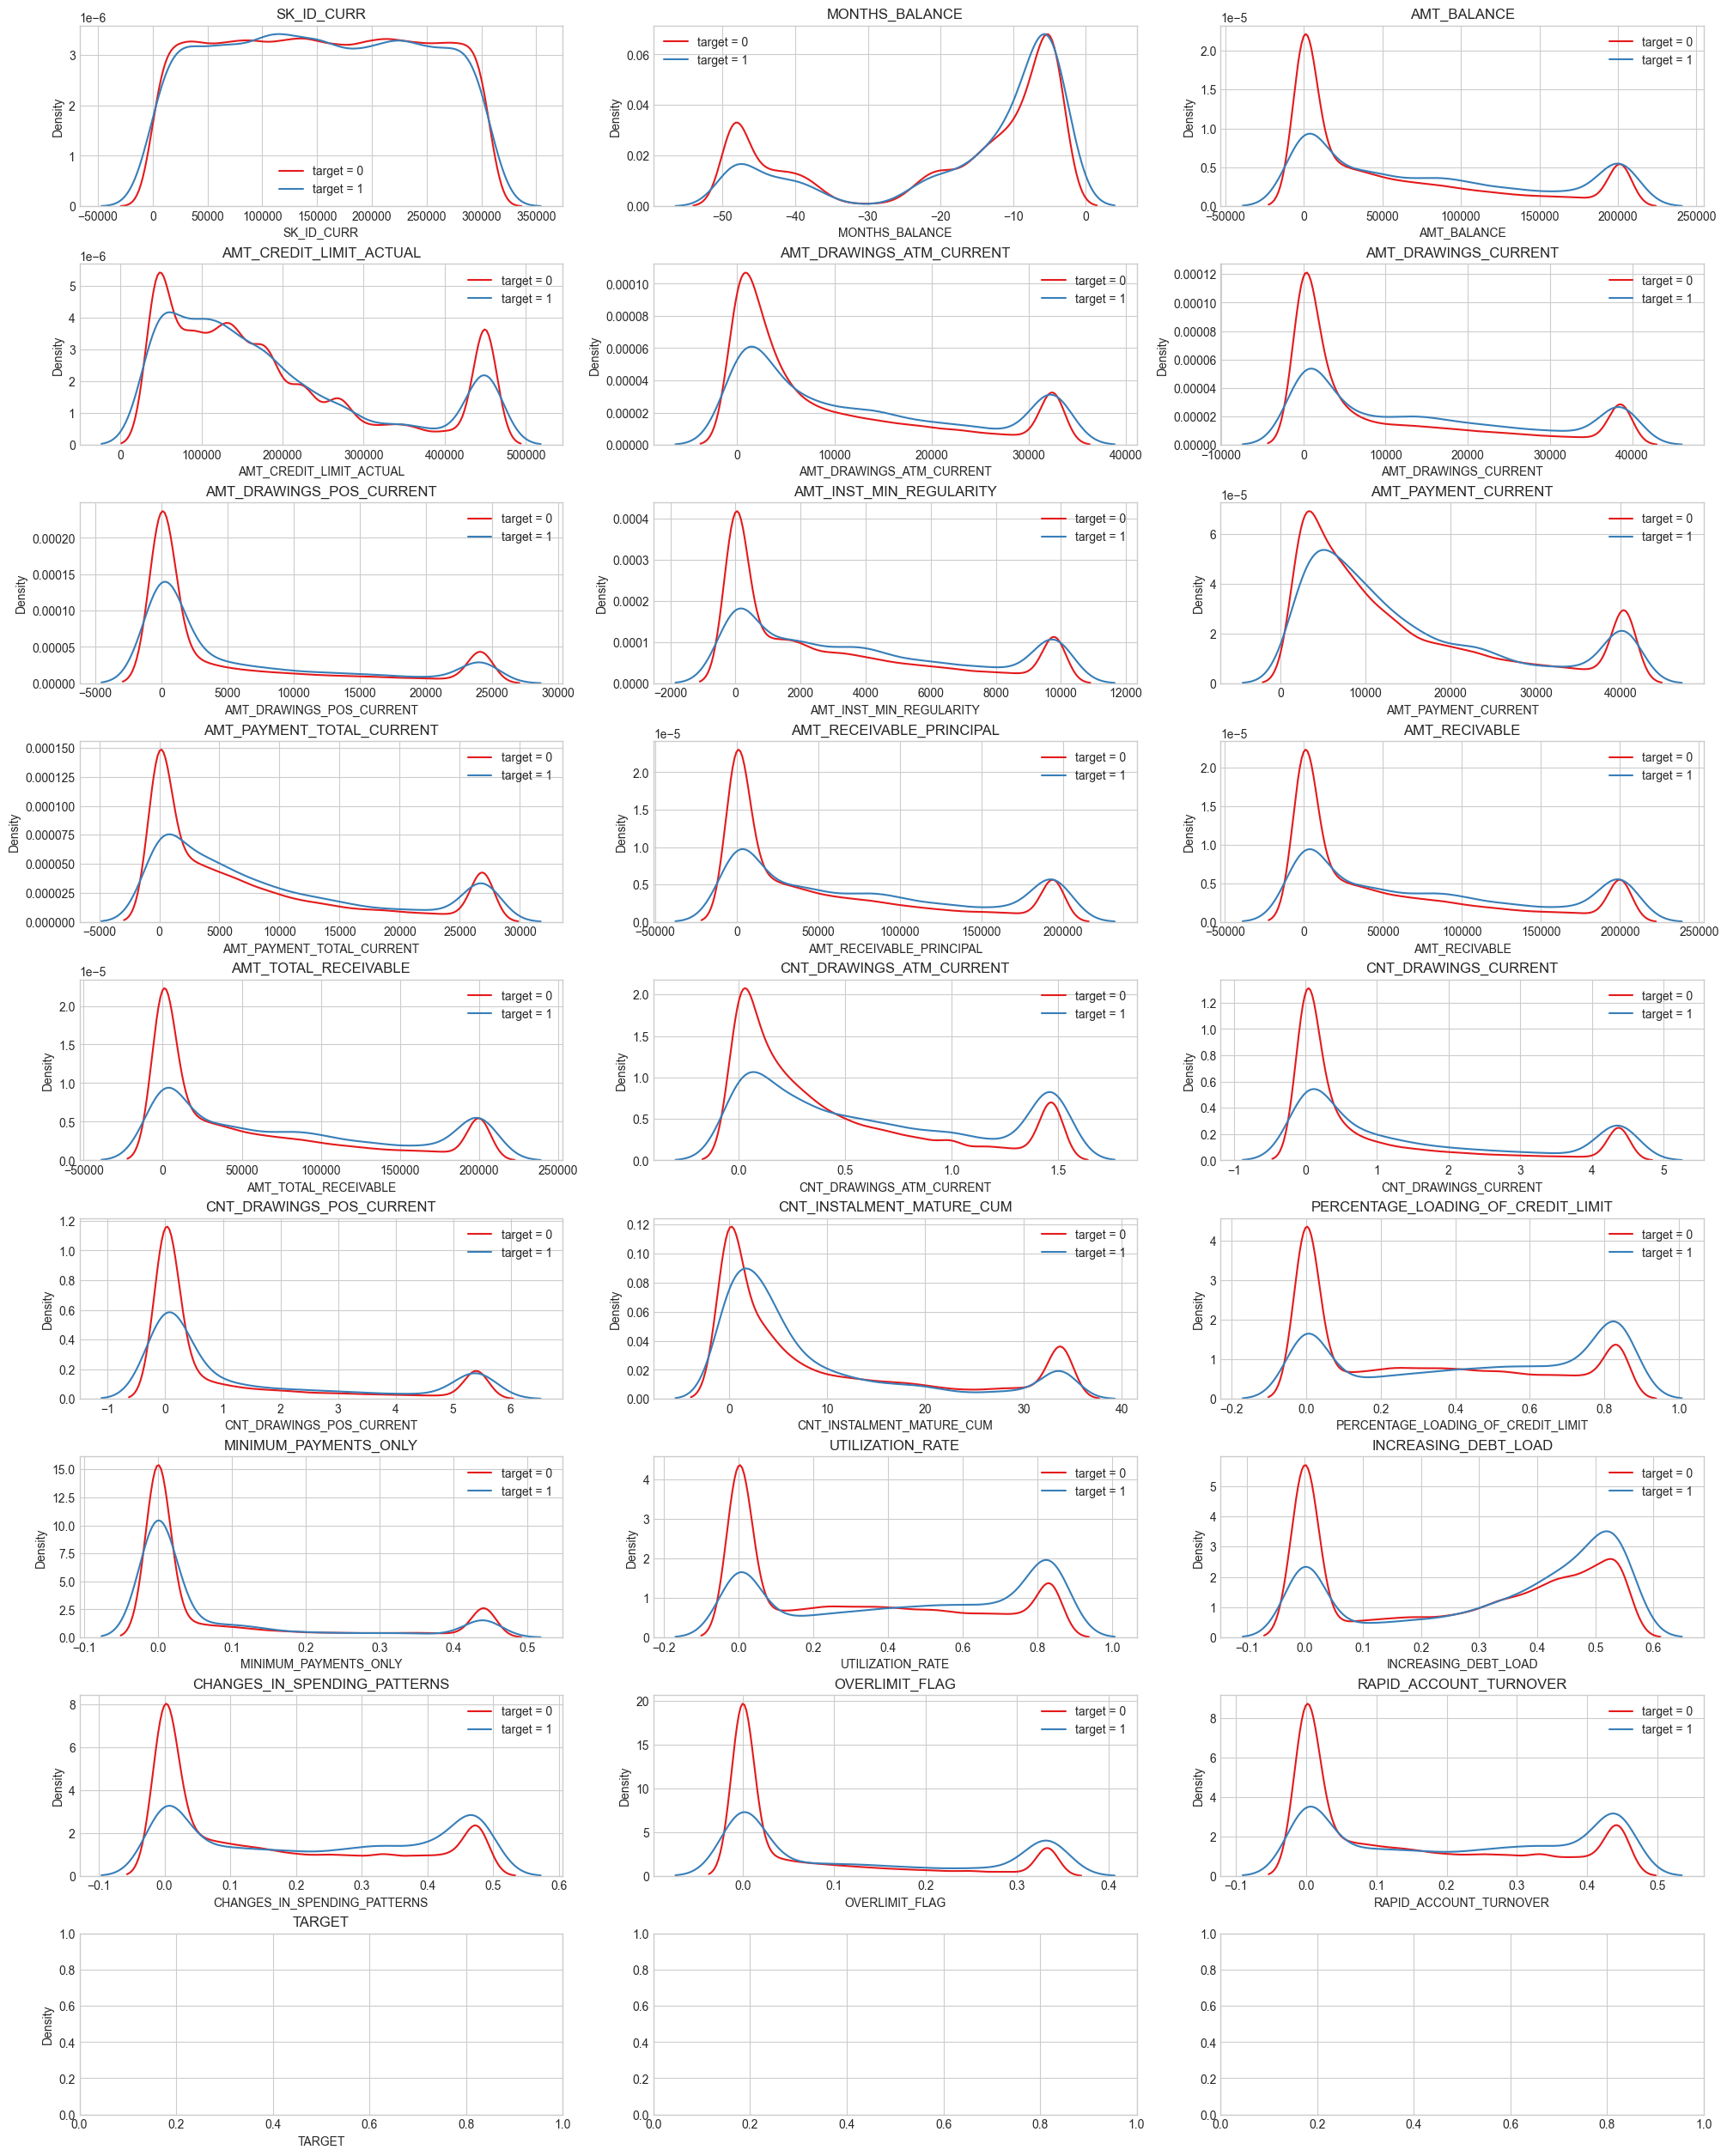

In [22]:
# Plot histogram of numerical columns var > 0.01
cols_to_plot = [col for col in df.columns if df[col].var() > 0.01]
ncol, nrow = 3, len(cols_to_plot)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.kdeplot(df.loc[df['TARGET'] == 0, column], ax=ax, label='target = 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, column], ax=ax, label='target = 1')
    ax.set_title(column)
    ax.legend()
plt.show()

## Max

In [23]:
# Inspect max values
max_df = grouped.max()
max_df = max_df.merge(target, on='SK_ID_CURR', how='left')

# Plot histogram of numerical columns var > 0.01
cols_to_plot = [col for col in num_cols if df[col].var() > 0.01]
ncol, nrow = 3, len(cols_to_plot)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.kdeplot(max_df.loc[max_df['TARGET'] == 0, column], ax=ax, label='target = 0')
    sns.kdeplot(max_df.loc[max_df['TARGET'] == 1, column], ax=ax, label='target = 1')
    ax.set_title(column)
    ax.legend()
plt.show()

KeyError: 'SK_ID_PREV'

## Min

/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_77636/1994703208.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(min_df.loc[min_df['TARGET'] == 1, column], ax=ax, label='target = 1')
/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_77636/1994703208.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(min_df.loc[min_df['TARGET'] == 0, column], ax=ax, label='target = 0')
/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_77636/1994703208.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(min_df.loc[min_df['TARGET'] == 1, column], ax=ax, label='target = 1')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argu

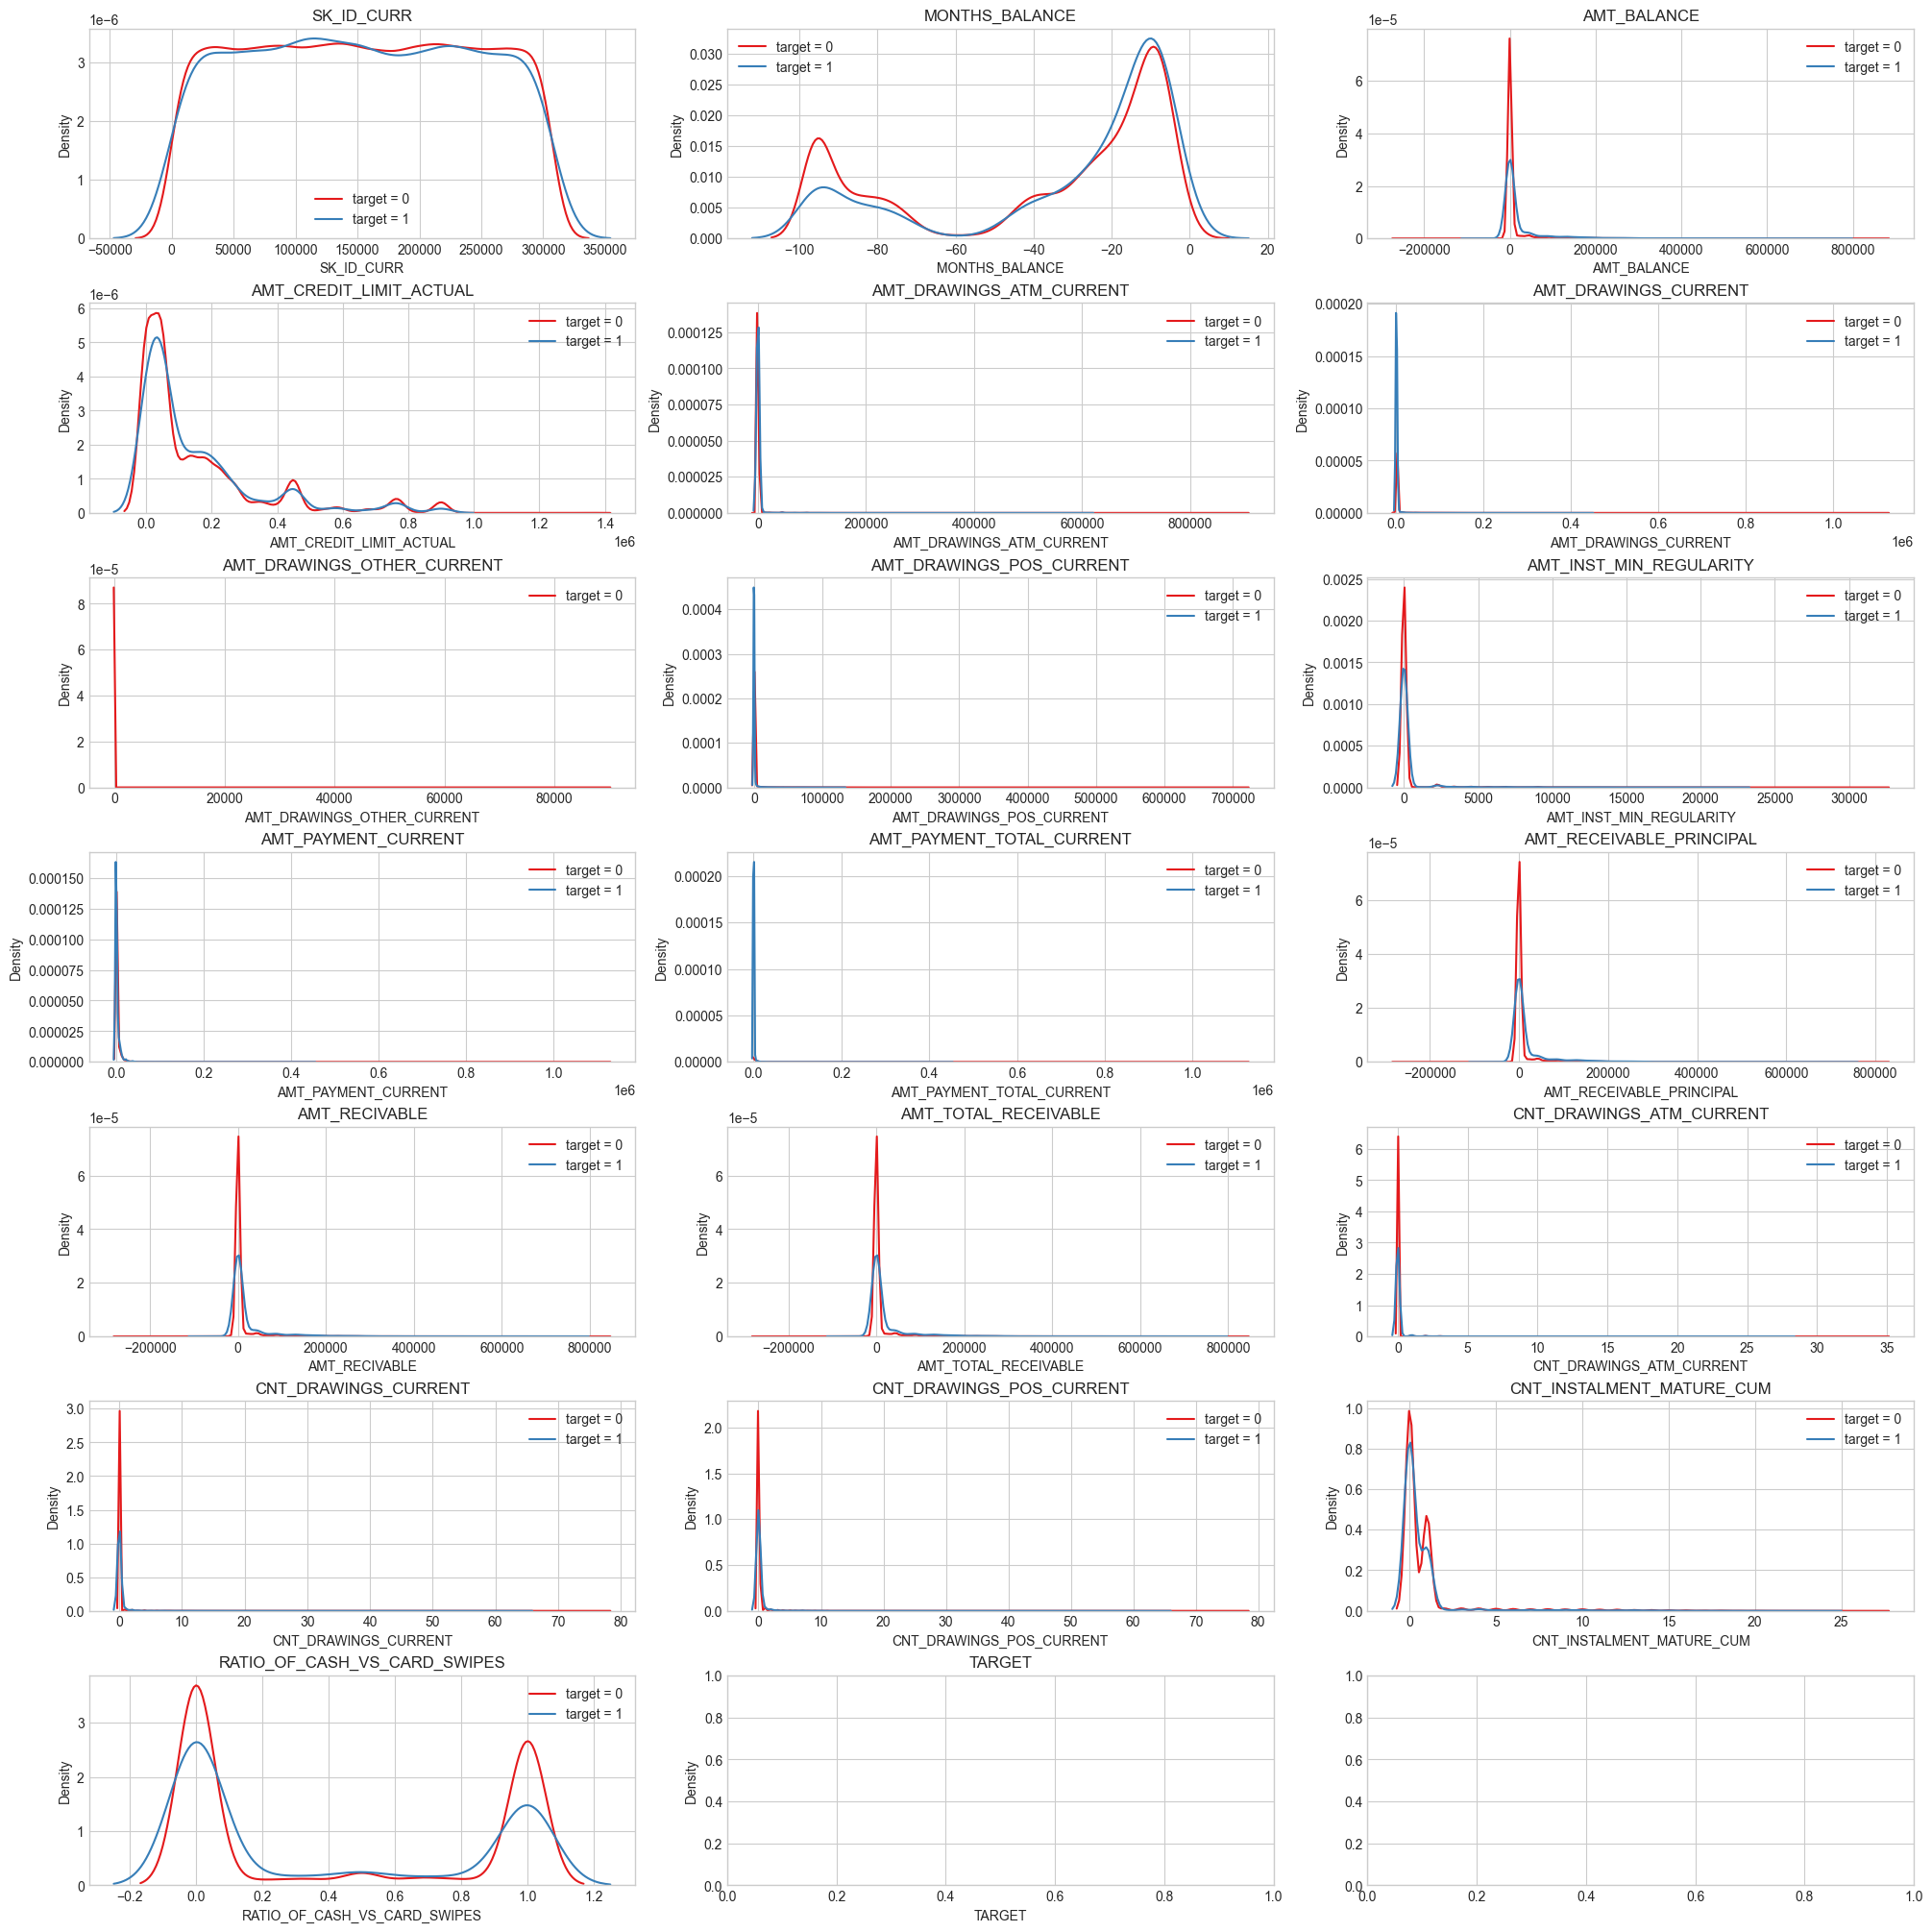

In [ ]:
min_df = grouped.min()
min_df = min_df.merge(target, on='SK_ID_CURR', how='left')

# Plot histogram of numerical columns var > 0.01
cols_to_plot = [col for col in min_df.columns if min_df[col].var() > 0.01]

ncol, nrow = 3, len(cols_to_plot)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.kdeplot(min_df.loc[min_df['TARGET'] == 0, column], ax=ax, label='target = 0')
    sns.kdeplot(min_df.loc[min_df['TARGET'] == 1, column], ax=ax, label='target = 1')
    ax.set_title(column)
    ax.legend()
plt.show()

## Var

/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_77636/4089940050.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(var_df.loc[var_df['TARGET'] == 0, column], ax=ax, label='target = 0')
/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_77636/4089940050.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(var_df.loc[var_df['TARGET'] == 1, column], ax=ax, label='target = 1')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


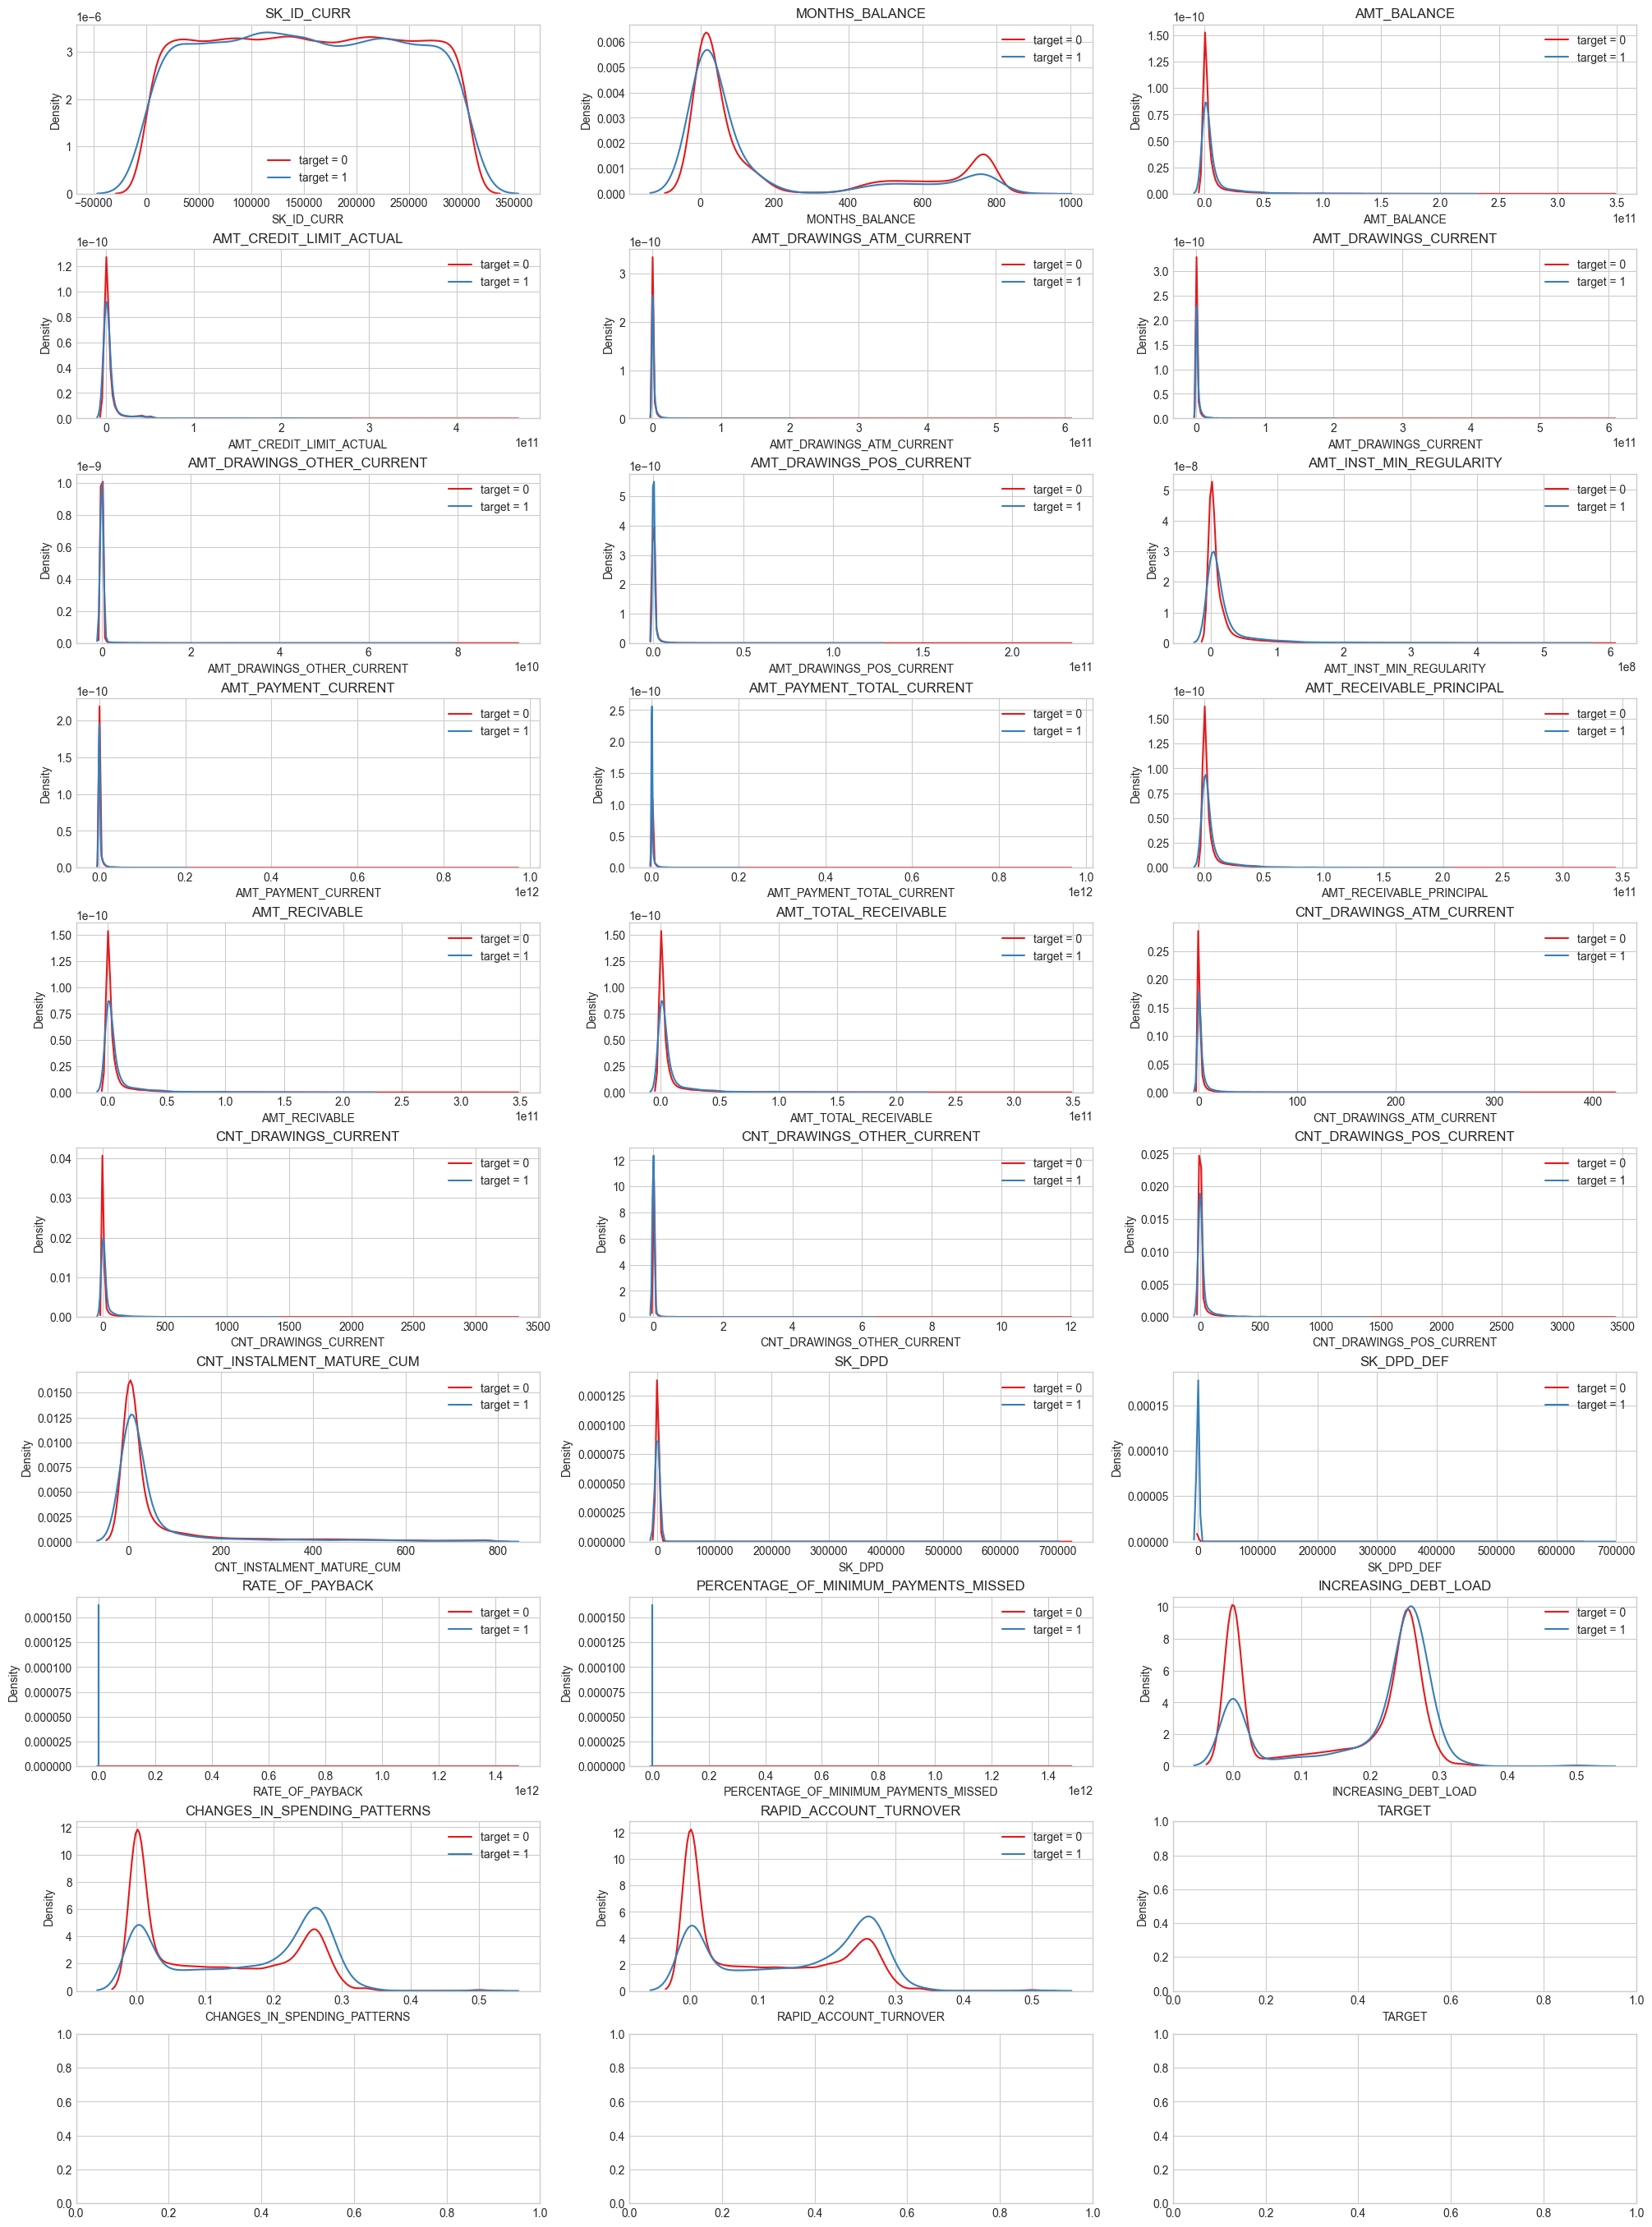

In [ ]:
var_df = grouped.var()
var_df = var_df.merge(target, on='SK_ID_CURR', how='left')

# Plot histogram of numerical columns var > 0.01
cols_to_plot = [col for col in var_df.columns if var_df[col].var() > 0.01]

ncol, nrow = 3, len(cols_to_plot)//3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.kdeplot(var_df.loc[var_df['TARGET'] == 0, column], ax=ax, label='target = 0')
    sns.kdeplot(var_df.loc[var_df['TARGET'] == 1, column], ax=ax, label='target = 1')
    ax.set_title(column)
    ax.legend()
plt.show()

# Feature Importance

In [ ]:
df = grouped.mean()
df = df.merge(target, on='SK_ID_CURR', how='left')
df.set_index('SK_ID_CURR', inplace=True)
df.head()

MONTHS_BALANCE    AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
SK_ID_CURR                                                           
0                     -4.5    6735.504375            180000.000000   
1                     -5.0  147180.880000            225000.000000   
3                     -6.0  124425.875455            135000.000000   
7                     -9.5       0.000000             62500.000000   
9                     -6.0     428.318182            163636.363636   

            AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
SK_ID_CURR                                                   
0                           0.000000          14053.455000   
1                       26000.000000          26000.000000   
3                           0.000000          17483.854091   
7                                NaN              0.000000   
9                        6218.181818           6218.181818   

            AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
SK_ID_CURR                                                         
0                                  0.0                14053.4550   
1                                  0.0                    0.0000   
3                                  0.0                19232.2395   
7                                  NaN                       NaN   
9                                  0.0                    0.0000   

            AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
SK_ID_CURR                                                 
0                        281.250000         14310.649286   
1                       6675.515000          7678.125000   
3                       5517.695455         10061.014500   
7                          0.000000                  NaN   
9                        204.545455          7131.285000   

            AMT_PAYMENT_TOTAL_CURRENT  ...  CHANGES_IN_SPENDING_PATTERNS  \
SK_ID_CURR                             ...                                 
0                        11959.318125  ...                      0.500000   
1                         6825.000000  ...                      0.333333   
3                         8511.680455  ...                      0.272727   
7                            0.000000  ...                      0.000000   
9                         7131.285000  ...                      0.090909   

            OVERLIMIT_FLAG  RAPID_ACCOUNT_TURNOVER  \
SK_ID_CURR                                           
0                 0.000000                0.500000   
1                 0.111111                0.222222   
3                 0.636364                0.454545   
7                 0.000000                0.000000   
9                 0.000000                0.090909   

            NAME_CONTRACT_STATUS_Approved  NAME_CONTRACT_STATUS_Completed  \
SK_ID_CURR                                                                  
0                                     0.0                        0.000000   
1                                     0.0                        0.000000   
3                                     0.0                        0.000000   
7                                     0.0                        0.166667   
9                                     0.0                        0.818182   

            NAME_CONTRACT_STATUS_Demand  NAME_CONTRACT_STATUS_Refused  \
SK_ID_CURR                                                              
0                                   0.0                           0.0   
1                                   0.0                           0.0   
3                                   0.0                           0.0   
7                                   0.0                           0.0   
9                                   0.0                           0.0   

            NAME_CONTRACT_STATUS_Sent proposal  NAME_CONTRACT_STATUS_Signed  \
SK_ID_CURR                                                                    
0                                          0.0                    

In [ ]:
# Replace inf with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
train_df = df.loc[df['TARGET'].notnull()]
test_df = df.loc[df['TARGET'].isnull()]

In [ ]:
# Binning Process
optb = BinningProcess(variable_names=train_df.columns.tolist(), min_prebin_size=0.05)
optb.fit(train_df, train_df['TARGET'])

summary_table = optb.summary().set_index('name')
summary_table.sort_values('iv', ascending=False, inplace=True)
summary_table

dtype   status  selected n_bins  \
name                                                                         
OVERLIMIT_FLAG                         numerical  OPTIMAL      True      6   
UTILIZATION_RATE                       numerical  OPTIMAL      True     10   
PERCENTAGE_LOADING_OF_CREDIT_LIMIT     numerical  OPTIMAL      True     10   
CNT_DRAWINGS_CURRENT                   numerical  OPTIMAL      True     10   
CNT_DRAWINGS_ATM_CURRENT               numerical  OPTIMAL      True      9   
RAPID_ACCOUNT_TURNOVER                 numerical  OPTIMAL      True      9   
CHANGES_IN_SPENDING_PATTERNS           numerical  OPTIMAL      True      8   
AMT_DRAWINGS_CURRENT                   numerical  OPTIMAL      True      6   
CNT_INSTALMENT_MATURE_CUM              numerical  OPTIMAL      True     10   
AMT_DRAWINGS_ATM_CURRENT               numerical  OPTIMAL      True      7   
AMT_BALANCE                            numerical  OPTIMAL      True      8   
AMT_TOTAL_RECEIVABLE                   numerical  OPTIMAL      True      8   
AMT_RECIVABLE                          numerical  OPTIMAL      True      8   
AMT_RECEIVABLE_PRINCIPAL               numerical  OPTIMAL      True      8   
INCREASING_DEBT_LOAD                   numerical  OPTIMAL      True      8   
CNT_DRAWINGS_POS_CURRENT               numerical  OPTIMAL      True      5   
RATIO_OF_CASH_VS_CARD_SWIPES           numerical  OPTIMAL      True      6   
AMT_DRAWINGS_POS_CURRENT               numerical  OPTIMAL      True      7   
AMT_INST_MIN_REGULARITY                numerical  OPTIMAL      True      7   
AMT_PAYMENT_CURRENT                    numerical  OPTIMAL      True      4   
AMT_PAYMENT_TOTAL_CURRENT              numerical  OPTIMAL      True      7   
CNT_DRAWINGS_OTHER_CURRENT             numerical  OPTIMAL      True      2   
AMT_DRAWINGS_OTHER_CURRENT             numerical  OPTIMAL      True      2   
PERCENTAGE_OF_MINIMUM_PAYMENTS_MISSED  numerical  OPTIMAL      True      3   
RATE_OF_PAYBACK                        numerical  OPTIMAL      True      3   
MONTHS_BALANCE                         numerical  OPTIMAL      True     10   
SK_DPD                                 numerical  OPTIMAL      True      4   
SK_DPD_DEF                             numerical  OPTIMAL      True      4   
AMT_CREDIT_LIMIT_ACTUAL                numerical  OPTIMAL      True      7   
MINIMUM_PAYMENTS_ONLY                  numerical  OPTIMAL      True      5   
NAME_CONTRACT_STATUS_Completed         numerical  OPTIMAL      True      3   
DPD_FLAG                               numerical  OPTIMAL      True      4   
NAME_CONTRACT_STATUS_Approved          numerical  OPTIMAL      True      1   
NAME_CONTRACT_STATUS_Demand            numerical  OPTIMAL      True      1   
NAME_CONTRACT_STATUS_Refused           numerical  OPTIMAL      True      1   
NAME_CONTRACT_STATUS_Sent proposal     numerical  OPTIMAL      True      1   
NAME_CONTRACT_STATUS_Signed            numerical  OPTIMAL      True      1   
TARGET                                 numerical  OPTIMAL      True      1   

                                             iv        js      gini  \
name                                                                  
OVERLIMIT_FLAG                         0.232552  0.028398   0.24199   
UTILIZATION_RATE                       0.224265  0.027462  0.260444   
PERCENTAGE_LOADING_OF_CREDIT_LIMIT     0.224265  0.027462  0.260444   
CNT_DRAWINGS_CURRENT                   0.203797  0.025171   0.24964   
CNT_DRAWINGS_ATM_CURRENT               0.202917  0.024939  0.247077   
RAPID_ACCOUNT_TURNOVER                 0.176644  0.021833  0.234334   
CHANGES_IN_SPENDING_PATTERNS            0.17259  0.021341  0.231513   
AMT_DRAWINGS_CURRENT                   0.163913  0.020316  0.218208   
CNT_INSTALMENT_MATURE_CUM              0.163385  0.020208  0.225129   
AMT_DRAWINGS_ATM_CURRENT               0.152687  0.018885  0.217495   
AMT_BALANCE                            0.149941  0.018576  0.216063   

In [ ]:
# Print nunique of each column
for col in df.columns:
    print(col, df[col].nunique())

MONTHS_BALANCE 459
AMT_BALANCE 59467
AMT_CREDIT_LIMIT_ACTUAL 11313
AMT_DRAWINGS_ATM_CURRENT 22420
AMT_DRAWINGS_CURRENT 49079
AMT_DRAWINGS_OTHER_CURRENT 3923
AMT_DRAWINGS_POS_CURRENT 33412
AMT_INST_MIN_REGULARITY 57389
AMT_PAYMENT_CURRENT 56764
AMT_PAYMENT_TOTAL_CURRENT 57833
AMT_RECEIVABLE_PRINCIPAL 58549
AMT_RECIVABLE 59521
AMT_TOTAL_RECEIVABLE 59521
CNT_DRAWINGS_ATM_CURRENT 3385
CNT_DRAWINGS_CURRENT 6584
CNT_DRAWINGS_OTHER_CURRENT 449
CNT_DRAWINGS_POS_CURRENT 5024
CNT_INSTALMENT_MATURE_CUM 13923
SK_DPD 3606
SK_DPD_DEF 1548
PERCENTAGE_LOADING_OF_CREDIT_LIMIT 58606
RATE_OF_PAYBACK 16641
DPD_FLAG 1422
PERCENTAGE_OF_MINIMUM_PAYMENTS_MISSED 16641
RATIO_OF_CASH_VS_CARD_SWIPES 12567
MINIMUM_PAYMENTS_ONLY 2484
UTILIZATION_RATE 58606
INCREASING_DEBT_LOAD 1698
CHANGES_IN_SPENDING_PATTERNS 1390
OVERLIMIT_FLAG 1823
RAPID_ACCOUNT_TURNOVER 1308
NAME_CONTRACT_STATUS_Approved 6
NAME_CONTRACT_STATUS_Completed 925
NAME_CONTRACT_STATUS_Demand 16
NAME_CONTRACT_STATUS_Refused 14
NAME_CONTRACT_STATUS_Sent

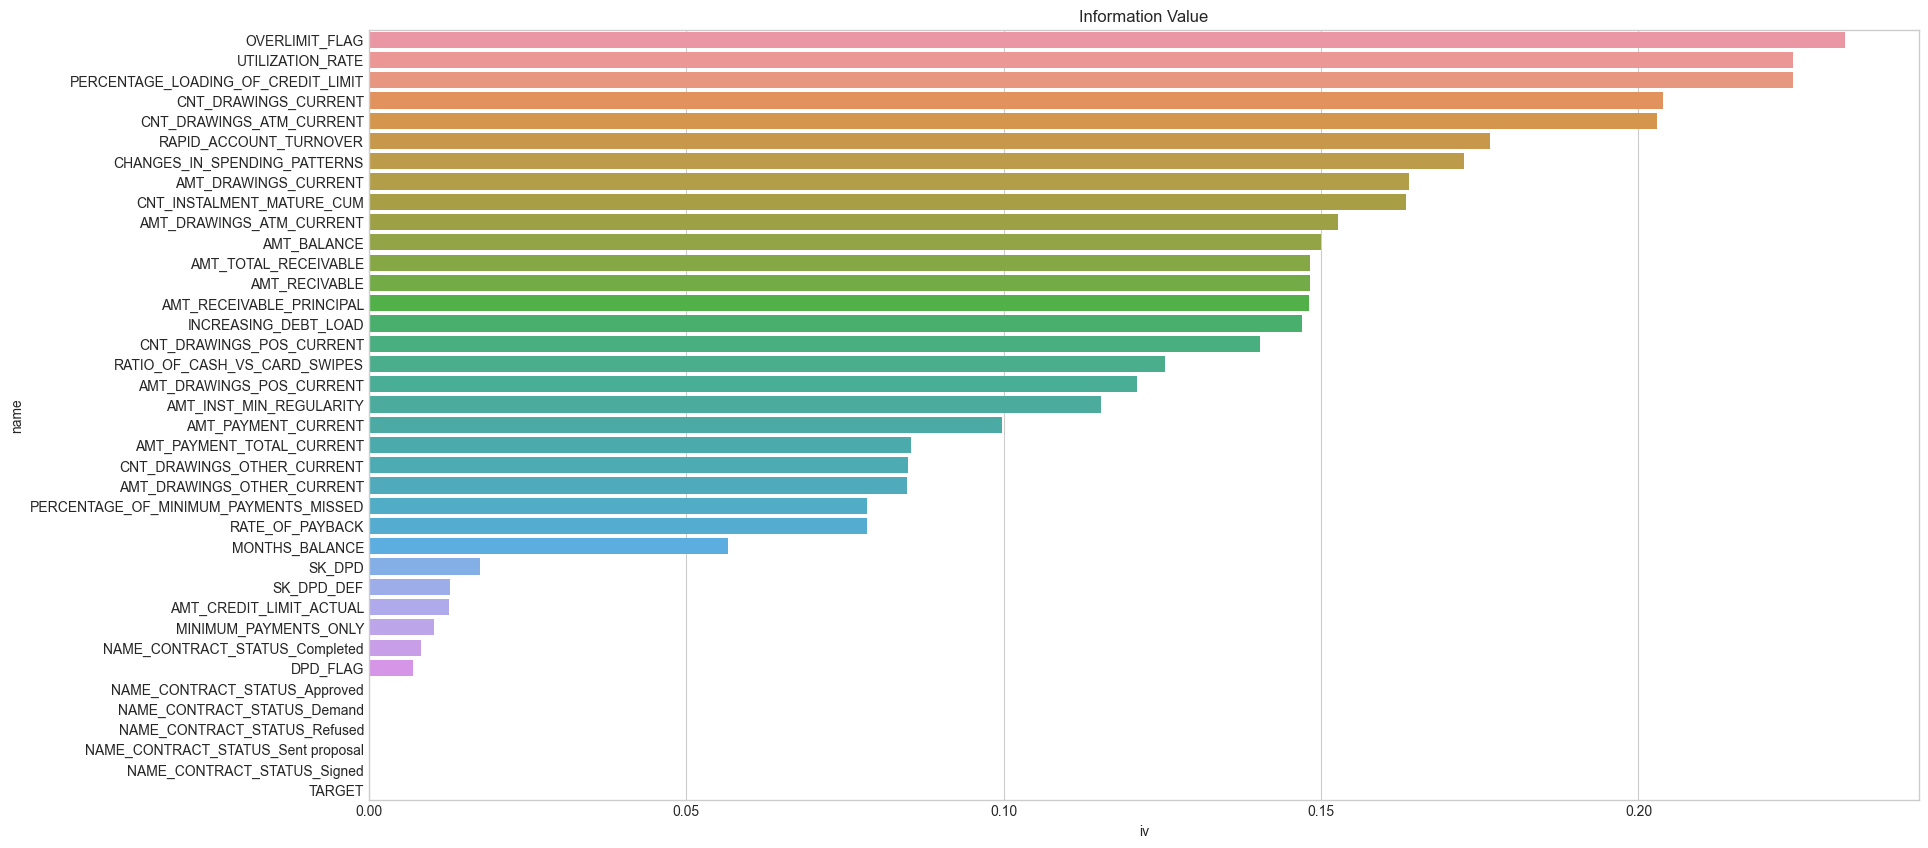

In [ ]:
# Plot IV
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x=summary_table['iv'], y=summary_table.index, ax=ax, orient='h')
ax.set_title('Information Value')
plt.show()

# Imp

In [24]:
df = df_copy.copy()
df.drop(columns=['SK_ID_PREV'], inplace=True)
df = create_features(df)
df.head()

MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  \
0              -1    63975.555                    45000   
1             -82    16809.210                    67500   
2             -84    27577.890                    67500   
3              -7    65159.235                    45000   
4             -59    70475.850                    67500   

   AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                    2250.0                2250.0                         0.0   
1                       0.0                   0.0                         0.0   
2                       0.0                   0.0                         0.0   
3                       0.0                   0.0                         0.0   
4                   24750.0               24750.0                         0.0   

   AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  \
0                       0.0                   2250.0               2250.0   
1                       0.0                   3375.0               9000.0   
2                       0.0                   3375.0               4500.0   
3                       0.0                   2250.0               2250.0   
4                       0.0                   3375.0               4500.0   

   AMT_PAYMENT_TOTAL_CURRENT  ...  PERCENTAGE_LOADING_OF_CREDIT_LIMIT  \
0                     2250.0  ...                            1.421679   
1                     9000.0  ...                            0.249025   
2                     4500.0  ...                            0.408561   
3                     2250.0  ...                            1.447983   
4                     4500.0  ...                            1.044087   

   RATE_OF_PAYBACK  DPD_FLAG  PERCENTAGE_OF_MINIMUM_PAYMENTS_MISSED  \
0         1.000000     False                               1.000000   
1         2.666667     False                               2.666667   
2         1.333333     False                               1.333333   
3         1.000000     False                               1.000000   
4         1.333333     False                               1.333333   

   MINIMUM_PAYMENTS_ONLY  UTILIZATION_RATE  INCREASING_DEBT_LOAD  \
0                   True          1.421679                 False   
1                  False          0.249025                 False   
2                  False          0.408561                  True   
3                   True          1.447983                  True   
4                  False          1.044087                  True   

   CHANGES_IN_SPENDING_PATTERNS OVERLIMIT_FLAG  RAPID_ACCOUNT_TURNOVER  
0                         False           True                   False  
1                         False          False                   False  
2                         False          False                   False  
3                         False           True                   False  
4                          True           True                    True  

[5 rows x 32 columns]

In [26]:
# One hot
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [32]:
grouped_df = df.groupby('SK_ID_CURR').agg(['mean', 'max', 'min', 'var'])
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
grouped_df.head()

MONTHS_BALANCE_mean  MONTHS_BALANCE_max  MONTHS_BALANCE_min  \
SK_ID_CURR                                                                
0                          -4.5                  -1                  -8   
1                          -5.0                  -1                  -9   
3                          -6.0                  -1                 -11   
7                          -9.5                  -1                 -18   
9                          -6.0                  -1                 -11   

            MONTHS_BALANCE_var  AMT_BALANCE_mean  AMT_BALANCE_max  \
SK_ID_CURR                                                          
0                          6.0       6735.504375        36569.430   
1                          7.5     147180.880000       227526.210   
3                         11.0     124425.875455       140704.965   
7                         28.5          0.000000            0.000   
9                         11.0        428.318182         4711.500   

            AMT_BALANCE_min  AMT_BALANCE_var  AMT_CREDIT_LIMIT_ACTUAL_mean  \
SK_ID_CURR                                                                   
0                       0.0     1.655502e+08                 180000.000000   
1                   15271.2     9.632267e+09                 225000.000000   
3                       0.0     1.721996e+09                 135000.000000   
7                       0.0     0.000000e+00                  62500.000000   
9                       0.0     2.018021e+06                 163636.363636   

            AMT_CREDIT_LIMIT_ACTUAL_max  ...  \
SK_ID_CURR                               ...   
0                                180000  ...   
1                                225000  ...   
3                                135000  ...   
7                                225000  ...   
9                                900000  ...   

            NAME_CONTRACT_STATUS_Refused_min  \
SK_ID_CURR                                     
0                                      False   
1                                      False   
3                                      False   
7                                      False   
9                                      False   

            NAME_CONTRACT_STATUS_Refused_var  \
SK_ID_CURR                                     
0                                        0.0   
1                                        0.0   
3                                        0.0   
7                                        0.0   
9                                        0.0   

            NAME_CONTRACT_STATUS_Sent proposal_mean  \
SK_ID_CURR                                            
0                                               0.0   
1                                               0.0   
3                                               0.0   
7                                               0.0   
9                                               0.0   

            NAME_CONTRACT_STATUS_Sent proposal_max  \
SK_ID_CURR                                           
0                                            False   
1                                            False   
3                                            False   
7                                            False   
9                                            False   

            NAME_CONTRACT_STATUS_Sent proposal_min  \
SK_ID_CURR                                           
0                                            False   
1                                            False   
3                                            False   
7                                            False   
9                                            False   

            NAME_CONTRACT_STATUS_Sent proposal_var  \
SK_ID_CURR                                           
0                                              0.0   
1                                              0.0   
3                                              0.0   
7                             

In [33]:
# Merge with target
grouped_df = grouped_df.merge(target, on='SK_ID_CURR', how='left')

# Replace inf with nan
grouped_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Split into train and test
train_df = grouped_df.loc[grouped_df['TARGET'].notnull()]
test_df = grouped_df.loc[grouped_df['TARGET'].isnull()]

# Binning Process
optb = BinningProcess(variable_names=train_df.columns.tolist(), min_prebin_size=0.05)
optb.fit(train_df, train_df['TARGET'])

summary_table = optb.summary().set_index('name')
summary_table.sort_values('iv', ascending=False, inplace=True)
summary_table

dtype   status  selected n_bins  \
name                                                                           
OVERLIMIT_FLAG_mean                      numerical  OPTIMAL      True      6   
UTILIZATION_RATE_mean                    numerical  OPTIMAL      True     10   
PERCENTAGE_LOADING_OF_CREDIT_LIMIT_mean  numerical  OPTIMAL      True     10   
OVERLIMIT_FLAG_var                       numerical  OPTIMAL      True      6   
CNT_DRAWINGS_CURRENT_var                 numerical  OPTIMAL      True      7   
...                                            ...      ...       ...    ...   
SK_DPD_DEF_min                           numerical  OPTIMAL      True      1   
OVERLIMIT_FLAG_min                       numerical  OPTIMAL      True      1   
DPD_FLAG_min                             numerical  OPTIMAL      True      1   
MINIMUM_PAYMENTS_ONLY_min                numerical  OPTIMAL      True      1   
TARGET                                   numerical  OPTIMAL      True      1   

                                               iv        js      gini  \
name                                                                    
OVERLIMIT_FLAG_mean                      0.232552  0.028398   0.24199   
UTILIZATION_RATE_mean                    0.224265  0.027462  0.260444   
PERCENTAGE_LOADING_OF_CREDIT_LIMIT_mean  0.224265  0.027462  0.260444   
OVERLIMIT_FLAG_var                       0.210698  0.025838  0.232181   
CNT_DRAWINGS_CURRENT_var                 0.206672  0.025494  0.251729   
...                                           ...       ...       ...   
SK_DPD_DEF_min                                0.0       0.0         0   
OVERLIMIT_FLAG_min                            0.0       0.0         0   
DPD_FLAG_min                                  0.0       0.0         0   
MINIMUM_PAYMENTS_ONLY_min                     0.0       0.0         0   
TARGET                                        0.0       0.0         0   

                                        quality_score  
name                                                   
OVERLIMIT_FLAG_mean                          0.529575  
UTILIZATION_RATE_mean                        0.421785  
PERCENTAGE_LOADING_OF_CREDIT_LIMIT_mean      0.421785  
OVERLIMIT_FLAG_var                           0.392253  
CNT_DRAWINGS_CURRENT_var                     0.621729  
...                                               ...  
SK_DPD_DEF_min                                    0.0  
OVERLIMIT_FLAG_min                                0.0  
DPD_FLAG_min                                      0.0  
MINIMUM_PAYMENTS_ONLY_min                         0.0  
TARGET                                            0.0  

[146 rows x 8 columns]

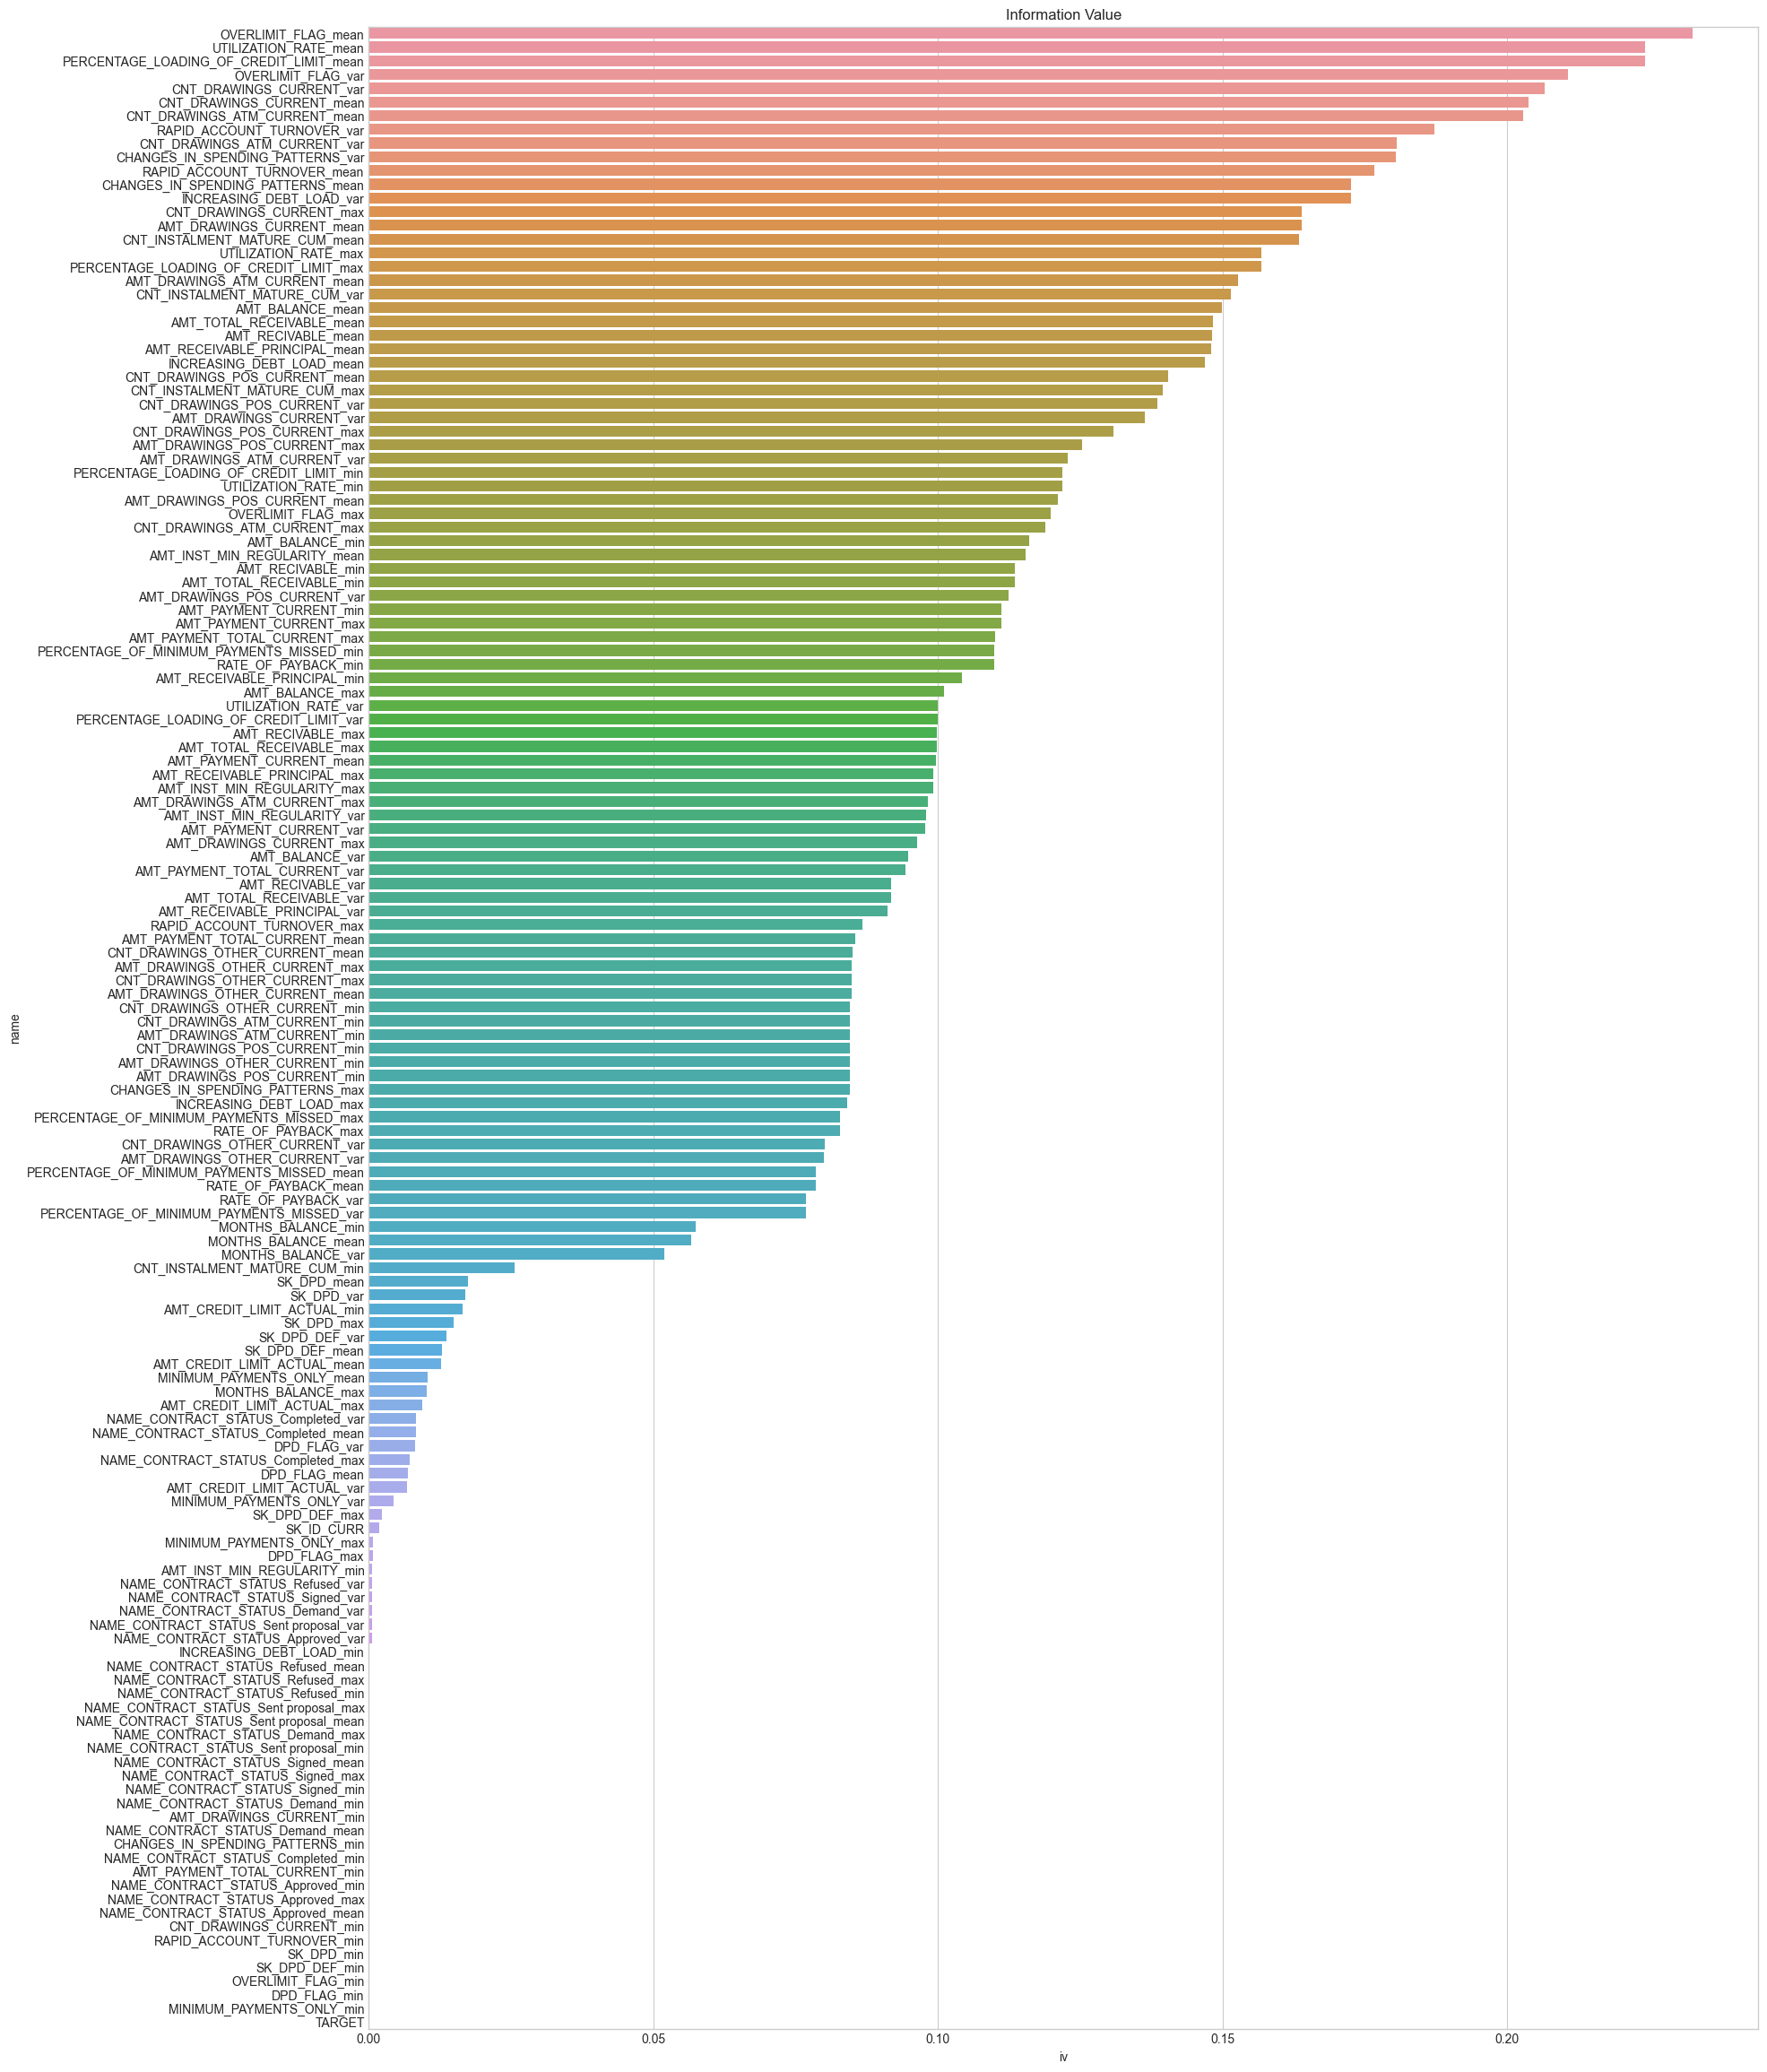

In [37]:
# Plot IV
fig, ax = plt.subplots(figsize=(20, len(summary_table)//5))
sns.barplot(x=summary_table['iv'], y=summary_table.index, ax=ax, orient='h')
ax.set_title('Information Value')
plt.show()

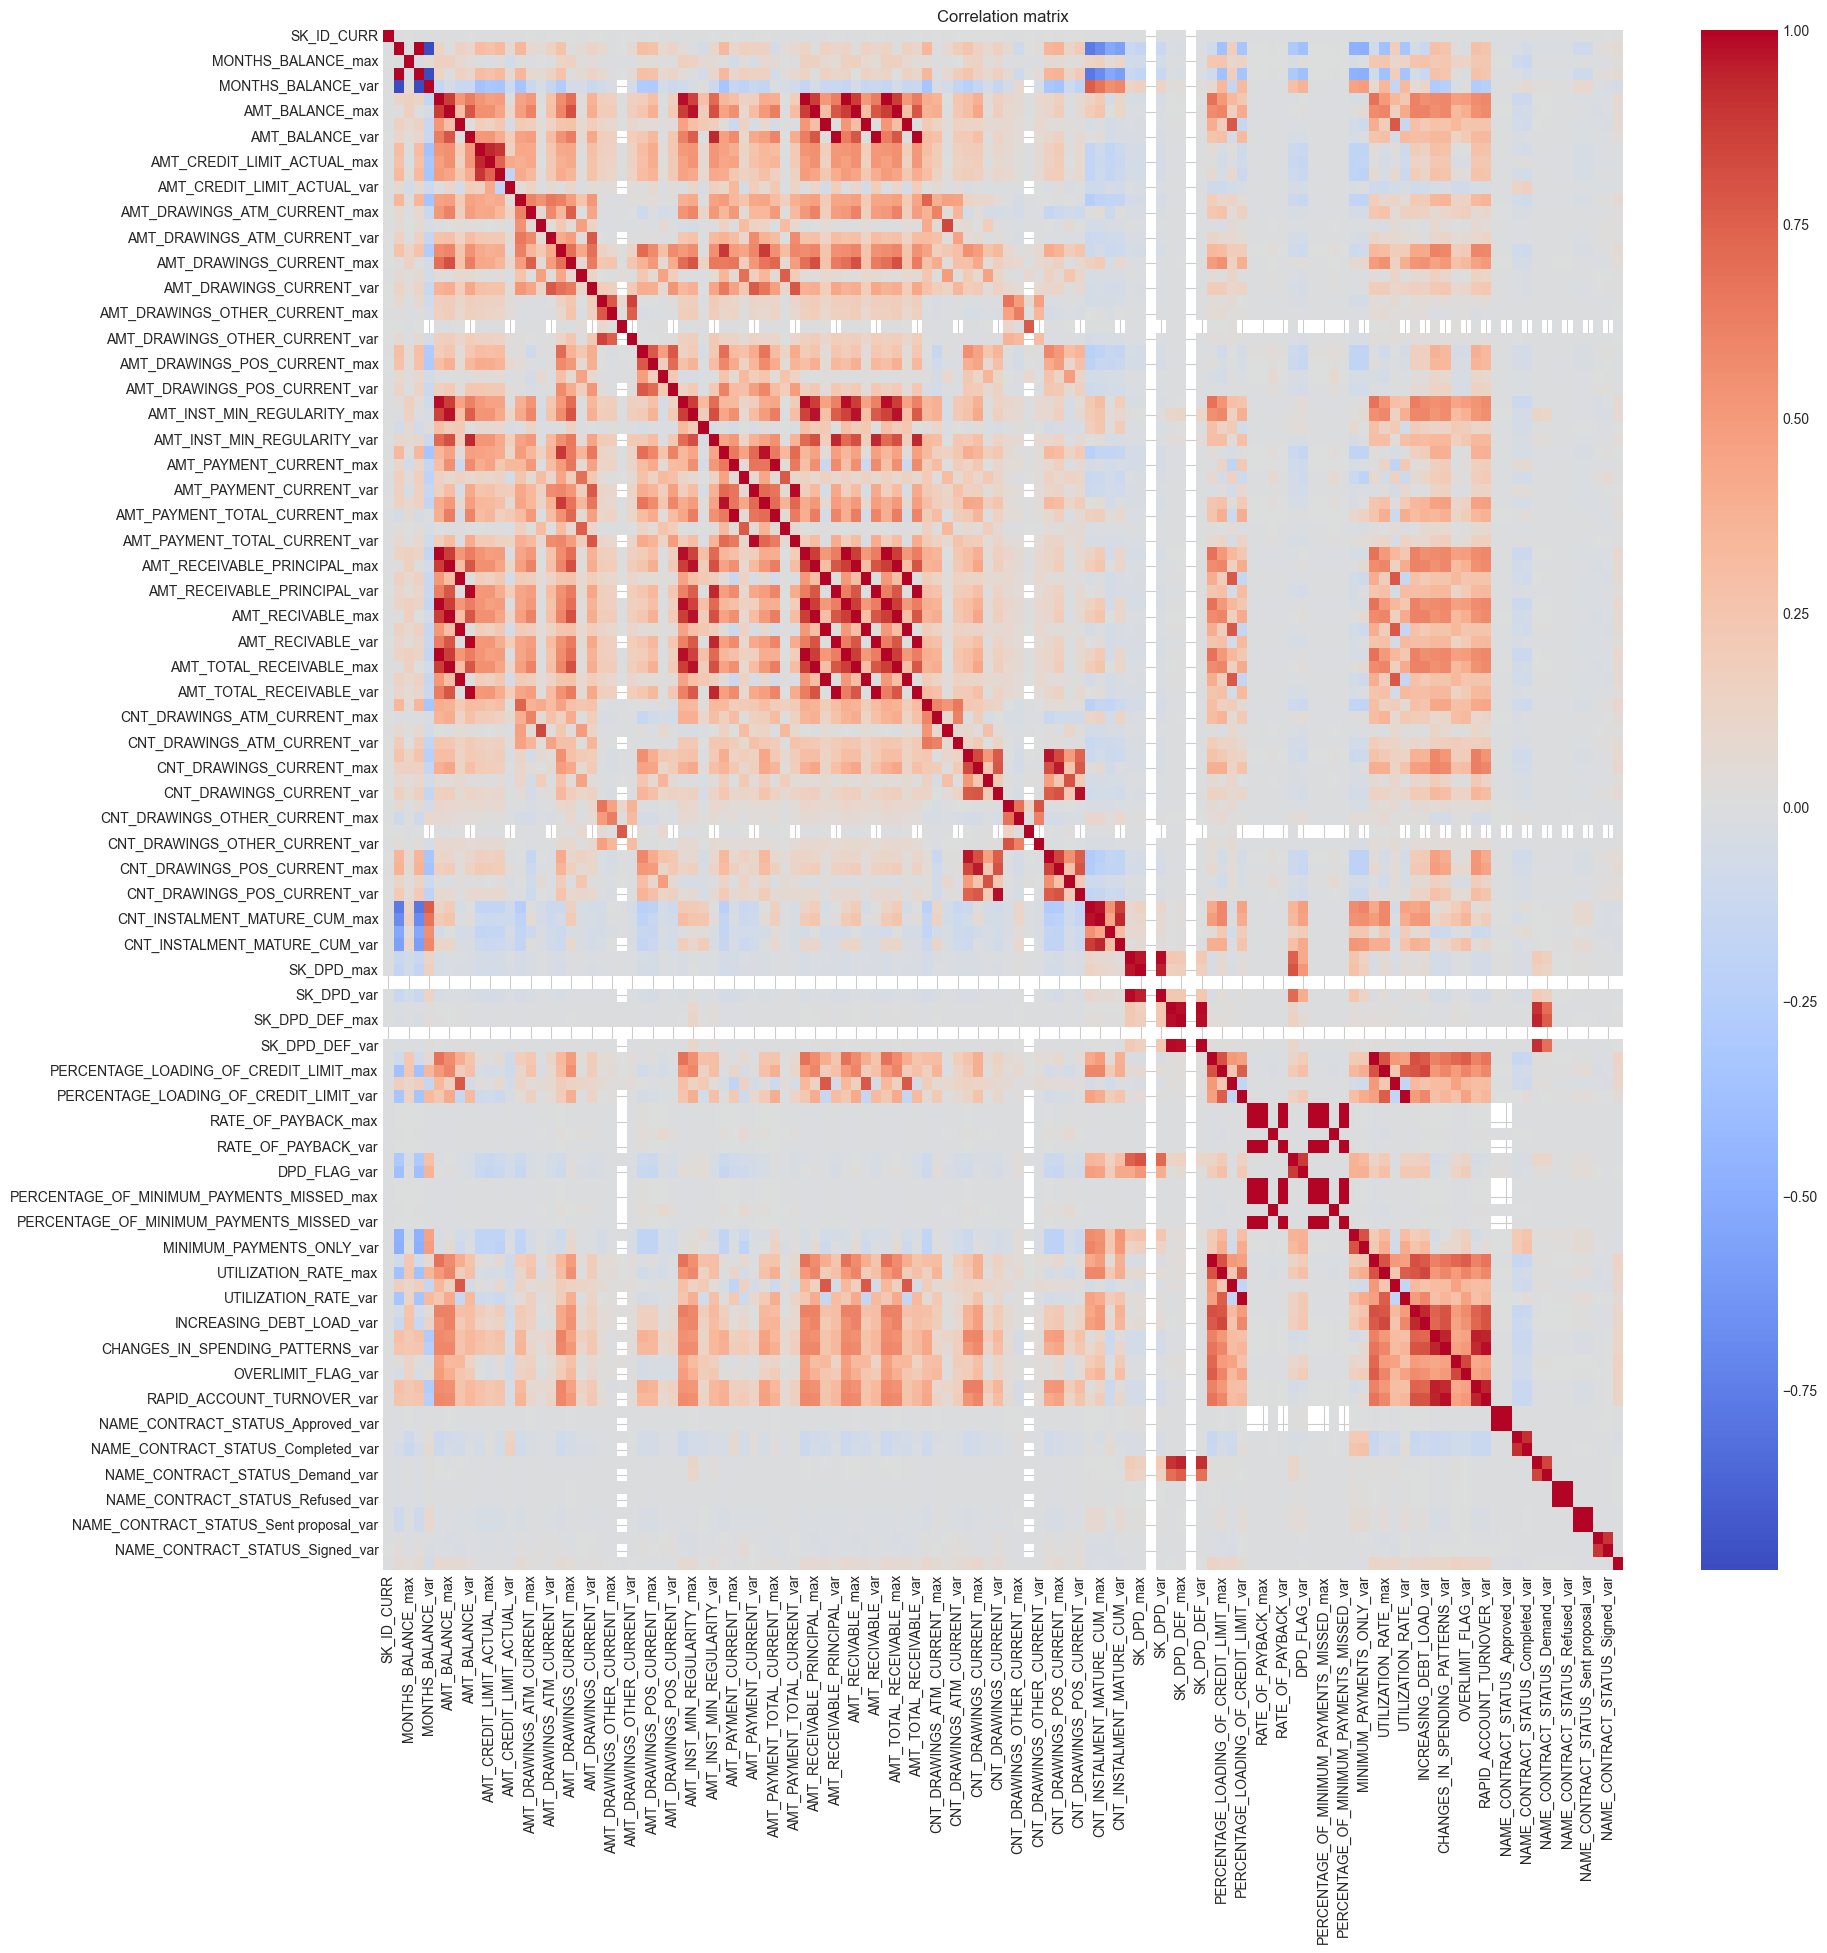

In [38]:
# Plot correlation matrix
fig, ax = plt.subplots(figsize=(20, 20))
num_cols = train_df.select_dtypes(include=np.number).columns.tolist()
sns.heatmap(train_df[num_cols].corr(), ax=ax,cmap='coolwarm')
ax.set_title('Correlation matrix')
plt.show()